 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Let's-figure-out-this-crap!" data-toc-modified-id="Let's-figure-out-this-crap!-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Let's figure out this crap!</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Visualize-the-task-of-the-network" data-toc-modified-id="Visualize-the-task-of-the-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualize the task of the network</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Train-Keras-networks" data-toc-modified-id="Train-Keras-networks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train Keras networks</a></span><ul class="toc-item"><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Fully-connected-neural-network" data-toc-modified-id="Fully-connected-neural-network-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Fully connected neural network</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Reproducing-the-results" data-toc-modified-id="Reproducing-the-results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Reproducing the results</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Keras--vs.-random-vs.-by-lon-train/valid-split" data-toc-modified-id="Keras--vs.-random-vs.-by-lon-train/valid-split-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Keras  vs. random vs. by-lon train/valid split</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#The-best-possible-(but-reasonable)-fully-connected-network" data-toc-modified-id="The-best-possible-(but-reasonable)-fully-connected-network-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>The best possible (but reasonable) fully connected network</a></span><ul class="toc-item"><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Train/valid-split-by-lon" data-toc-modified-id="Train/valid-split-by-lon-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>Train/valid split by lon</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Random-train-valid-split-with-old-mean/std" data-toc-modified-id="Random-train-valid-split-with-old-mean/std-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>Random train valid split with old mean/std</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Random-train-valid-split-with-new-mean/std" data-toc-modified-id="Random-train-valid-split-with-new-mean/std-4.4.3"><span class="toc-item-num">4.4.3&nbsp;&nbsp;</span>Random train valid split with new mean/std</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#With-tanh-activation" data-toc-modified-id="With-tanh-activation-4.4.4"><span class="toc-item-num">4.4.4&nbsp;&nbsp;</span>With tanh activation</a></span></li></ul></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Convolutional-neural-network" data-toc-modified-id="Convolutional-neural-network-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Convolutional neural network</a></span></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#A-more-complex-CNN" data-toc-modified-id="A-more-complex-CNN-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>A more complex CNN</a></span></li></ul></li><li><span><a href="http://localhost:8887/notebooks/keras/keras_experiments.ipynb#Visualize-predictions" data-toc-modified-id="Visualize-predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize predictions</a></span></li></ul></div>

# A Keras implementation of CBRAIN

In this notebook I am going to write my own implementation of CBRAIN, mostly in Keras. Primarily I am doing this so that I actually understand what is going on.

This notebook uses functions and classes which are defined in the following helper scripts:
- `utils.py`: General utility functions including visualization
- `data_generator.py`: Definition of DataGenerator and DataSet class. The former is not used at the moment.
- `models.py`: Definition of the Keras neural nets
- `losses.py`: Definition of the custom loss functions
- `run_experiments.py`: Wrapper script to run experiments outside of notebook

**TODO**
- Visualize predictions: How good are they really?
    - Are there biases?
    - Are there lat-z regions where errors are particularly high?
- Write convenient run_experiment script
- DataLoading function for RNNs and CNNs

## Setup

Import modules, define paths and variables.

In [36]:
# Imports
from importlib import reload
import utils; reload(utils);
from utils import *
import data_generator; reload(data_generator);
from data_generator import *
import models; reload(models);
from models import *
%matplotlib inline
np.random.seed(42)
sns.set_style('dark')
sns.set_palette('deep')
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (10,7)

In [3]:
# Limit Tensorflow GPU memory usage. 
# Note that apparently it's not possible to change the allocation or release memory again.
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5   # GPU RAM usage fraction of 4GB
sess = tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(sess)

In [6]:
# Define data paths
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/preprocessed_data/detailed_files/' # Full dataset
data_dir_old = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/preprocessed_data/Pierres_files/'

In [5]:
# Define a dictionary containing the feature and target variables
# and the number of dimensions
feature_vars = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'OMEGA': 2,           # [z, sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'QRL': 2,             # Long wave heating rate [z, sample]
    'QRS': 2,             # Short wave heating rate [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
    'LAT': 1,             # Latitude [sample]
})
target_vars = OrderedDict({
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
})

## Let's figure out this crap!

In [5]:
# Step one. Open raw flat preprocessed files and check whether they are the same.
nc_old = nc.Dataset(data_dir_old + 'SPCAM_outputs.nc', 'r')
nc_new = nc.Dataset(data_dir + 'SPCAM_outputs_flat.nc', 'r')

In [6]:
for var_name in nc_new.variables.keys():
    print(var_name)
    print(np.allclose(nc_old.variables[var_name][:], nc_new.variables[var_name][:]))

TAP
True
QAP
True
OMEGA
True
SHFLX
True
LHFLX
True
LAT
True
dTdt_adiabatic
True
dQdt_adiabatic
True
QRL
True
QRS
True
SPDT
True
SPDQ
True


In [7]:
nc_old.variables['OMEGA'][:, 0], nc_new.variables['OMEGA'][:, 0]

(array([ -8.41248620e-05,  -6.71216912e-05,  -4.58156836e-04,
          3.87695254e-05,  -3.10782855e-03,  -7.97972828e-03,
         -8.35774653e-03,   4.55843750e-04,   1.73452757e-02,
          2.57692561e-02,   2.20519379e-02,   1.62272900e-02,
          1.32723870e-02,   1.41674792e-02,   1.58010777e-02,
          1.38653312e-02,   8.37509707e-03,   3.13174189e-03,
          2.48683128e-03,   3.91008332e-03,   3.75890359e-03]),
 array([ -8.41248620e-05,  -6.71216912e-05,  -4.58156836e-04,
          3.87695254e-05,  -3.10782855e-03,  -7.97972828e-03,
         -8.35774653e-03,   4.55843750e-04,   1.73452757e-02,
          2.57692561e-02,   2.20519379e-02,   1.62272900e-02,
          1.32723870e-02,   1.41674792e-02,   1.58010777e-02,
          1.38653312e-02,   8.37509707e-03,   3.13174189e-03,
          2.48683128e-03,   3.91008332e-03,   3.75890359e-03], dtype=float32))

In [9]:
# Load one raw file and check out omega
raw_nc = nc.Dataset('/project/meteo/w2w/A6/S.Rasp/SP-CAM/Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0000-01-01-00000.nc', 'r')

In [11]:
raw_nc.variables['OMEGA'][1, :, 0, 0], nc_old.variables['OMEGA'][:, 0], nc_new.variables['OMEGA'][:, 0]

(array([ -4.91468782e-05,  -5.47033706e-05,   8.33931117e-05,
         -1.64841491e-04,  -4.29021951e-04,  -2.71149707e-04,
         -3.80044148e-05,   3.31080082e-04,   1.12691363e-04,
         -8.41248620e-05,  -6.71216912e-05,  -4.58156836e-04,
          3.87695254e-05,  -3.10782855e-03,  -7.97972828e-03,
         -8.35774653e-03,   4.55843750e-04,   1.73452757e-02,
          2.57692561e-02,   2.20519379e-02,   1.62272900e-02,
          1.32723870e-02,   1.41674792e-02,   1.58010777e-02,
          1.38653312e-02,   8.37509707e-03,   3.13174189e-03,
          2.48683128e-03,   3.91008332e-03,   3.75890359e-03], dtype=float32),
 array([ -8.41248620e-05,  -6.71216912e-05,  -4.58156836e-04,
          3.87695254e-05,  -3.10782855e-03,  -7.97972828e-03,
         -8.35774653e-03,   4.55843750e-04,   1.73452757e-02,
          2.57692561e-02,   2.20519379e-02,   1.62272900e-02,
          1.32723870e-02,   1.41674792e-02,   1.58010777e-02,
          1.38653312e-02,   8.37509707e-03,   3.13174

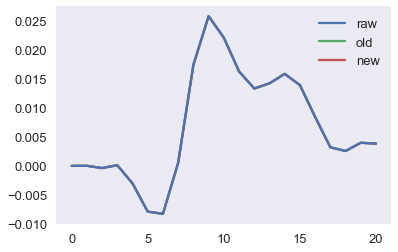

In [12]:
plt.plot(raw_nc.variables['OMEGA'][1, 9:, 0, 0], label='raw', zorder=10)
plt.plot(nc_old.variables['OMEGA'][:, 0], label='old')
plt.plot(nc_new.variables['OMEGA'][:, 0], label='new')
plt.legend()

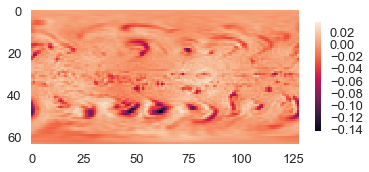

In [13]:
plt.imshow(raw_nc.variables['OMEGA'][10, -1, :, :])
plt.colorbar(shrink=0.5)

Ok so OMEGA is a little different, or whatever reason. Let's now load it into a dataset with the same mean and std

In [14]:
nc_old.close(), nc_new.close()

(None, None)

In [15]:
old_set = DataSet(data_dir_old, 'SPCAM_outputs.nc', 'SPCAM_mean.nc', 'SPCAM_std.nc', 
                  feature_vars.keys(), flat_input=True)

In [16]:
new_set = DataSet(data_dir, 'SPCAM_outputs_flat.nc', 'SPCAM_mean.nc', 'SPCAM_std.nc', 
                  feature_vars.keys(), flat_input=True, mean_std_dir=data_dir_old)

In [28]:
new_norm_set = DataSet(data_dir, 'SPCAM_outputs_flat.nc', 'SPCAM_mean_detailed.nc', 'SPCAM_std_detailed.nc', 
                  feature_vars.keys(), flat_input=True)

In [30]:
new_cov_set = DataSet(data_dir, 'SPCAM_outputs_detailed.nc', 'SPCAM_mean_detailed.nc', 'SPCAM_std_detailed.nc', 
                  feature_vars.keys())

In [34]:
np.array_equal(new_norm_set.features, new_cov_set.features)

True

In [17]:
old_set.feature_names

odict_keys(['TAP', 'QAP', 'OMEGA', 'dTdt_adiabatic', 'dQdt_adiabatic', 'QRL', 'QRS', 'SHFLX', 'LHFLX', 'LAT'])

In [18]:
old_set.features[0, 42:63], new_set.features[0, 42:63]

(array([ 0.05240592,  0.08580943,  0.11380135,  0.14332837,  0.11570902,
         0.0706427 ,  0.06369621,  0.13417509,  0.27979112,  0.3535845 ,
         0.3167111 ,  0.26593688,  0.24173288,  0.24990746,  0.27118689,
         0.27858374,  0.26214781,  0.2328486 ,  0.25151622,  0.35305262,
         0.46764424], dtype=float32),
 array([ 0.05240592,  0.08580943,  0.11380135,  0.14332837,  0.11570902,
         0.0706427 ,  0.06369621,  0.13417509,  0.27979112,  0.3535845 ,
         0.3167111 ,  0.26593688,  0.24173288,  0.24990746,  0.27118689,
         0.27858374,  0.26214781,  0.2328486 ,  0.25151622,  0.35305262,
         0.46764424], dtype=float32))

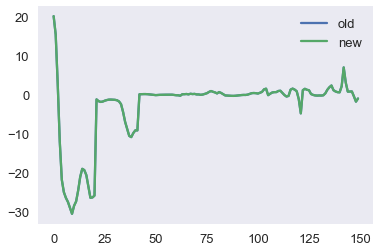

In [19]:
i = 100000
plt.plot(old_set.features[i, :], label='old')
plt.plot(new_set.features[i, :], label='new')
plt.legend()

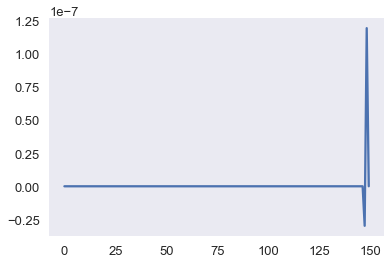

In [20]:
plt.plot(old_set.features[i, :] - new_set.features[i, :])

In [21]:
s1 = np.sum(np.abs(old_set.features[:, :] - new_set.features[:, :]), axis=0)

In [22]:
s1[-4:]

array([ 0.        ,  0.34569576,  0.16455804,  0.0699234 ], dtype=float32)

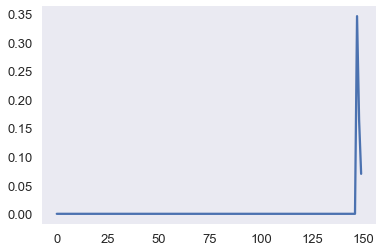

In [23]:
plt.plot(s1)

In [24]:
model = fc_model(old_set.features.shape[1], old_set.targets.shape[1], 
                 [32, 32], 0.001, 'mae')

In [25]:
model.fit(old_set.features, old_set.targets, batch_size=4096, epochs=7)

Epoch 1/7
4620288/4620288 [==============================] - 17s - loss: 0.0684 - rmse: 0.0998 - log_loss: -1.4387 - total_error: 724.0102 - unexplained_error: 31475.3445 - rsquared: -42.6217 - total_error_avgAx0: 629.3391 - rsquared_avgAx0: -49.1771    
Epoch 2/7
4620288/4620288 [==============================] - 16s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0101 - unexplained_error: 649.9210 - rsquared: 0.1025 - total_error_avgAx0: 629.3368 - rsquared_avgAx0: -0.0327    
Epoch 3/7
4620288/4620288 [==============================] - 16s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0101 - unexplained_error: 649.8523 - rsquared: 0.1026 - total_error_avgAx0: 629.3403 - rsquared_avgAx0: -0.0326    
Epoch 4/7
4620288/4620288 [==============================] - 16s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0101 - unexplained_error: 649.7777 - rsquared: 0.1027 - total_error_avgAx0: 629.3370 - rsquared_avgAx0: -0.0325

In [26]:
model = fc_model(new_set.features.shape[1], new_set.targets.shape[1], 
                 [32, 32], 0.001, 'mae')

In [27]:
model.fit(new_set.features, new_set.targets, batch_size=4096, epochs=7)

Epoch 1/7
4620288/4620288 [==============================] - 17s - loss: 0.0645 - rmse: 0.0930 - log_loss: -1.4593 - total_error: 724.0100 - unexplained_error: 31152.1658 - rsquared: -42.5697 - total_error_avgAx0: 629.3378 - rsquared_avgAx0: -49.1693    
Epoch 2/7
4620288/4620288 [==============================] - 16s - loss: 0.0223 - rmse: 0.0407 - log_loss: -1.5307 - total_error: 724.0101 - unexplained_error: 542.6427 - rsquared: 0.2503 - total_error_avgAx0: 629.3372 - rsquared_avgAx0: 0.1374    
Epoch 3/7
4620288/4620288 [==============================] - 16s - loss: 0.0222 - rmse: 0.0406 - log_loss: -1.5319 - total_error: 724.0101 - unexplained_error: 538.2361 - rsquared: 0.2564 - total_error_avgAx0: 629.3399 - rsquared_avgAx0: 0.1444    
Epoch 4/7
4620288/4620288 [==============================] - 16s - loss: 0.0222 - rmse: 0.0405 - log_loss: -1.5326 - total_error: 724.0101 - unexplained_error: 535.5600 - rsquared: 0.2600 - total_error_avgAx0: 629.3355 - rsquared_avgAx0: 0.1486   

In [29]:
model = fc_model(new_norm_set.features.shape[1], new_norm_set.targets.shape[1], 
                 [32, 32], 0.001, 'mae')
model.fit(new_norm_set.features, new_norm_set.targets, batch_size=4096, epochs=7)

Epoch 1/7
4620288/4620288 [==============================] - 17s - loss: 0.0287 - rmse: 0.0474 - log_loss: -1.5061 - total_error: 724.0101 - unexplained_error: 1054.9585 - rsquared: -0.4536 - total_error_avgAx0: 629.3416 - rsquared_avgAx0: -0.6713    
Epoch 2/7
4620288/4620288 [==============================] - 16s - loss: 0.0204 - rmse: 0.0374 - log_loss: -1.5739 - total_error: 724.0100 - unexplained_error: 461.1673 - rsquared: 0.3629 - total_error_avgAx0: 629.3357 - rsquared_avgAx0: 0.2669    
Epoch 3/7
4620288/4620288 [==============================] - 16s - loss: 0.0196 - rmse: 0.0360 - log_loss: -1.5893 - total_error: 724.0101 - unexplained_error: 428.1834 - rsquared: 0.4085 - total_error_avgAx0: 629.3386 - rsquared_avgAx0: 0.3194    
Epoch 4/7
4620288/4620288 [==============================] - 16s - loss: 0.0193 - rmse: 0.0356 - log_loss: -1.5948 - total_error: 724.0102 - unexplained_error: 421.0724 - rsquared: 0.4183 - total_error_avgAx0: 629.3392 - rsquared_avgAx0: 0.3307    
E

In [68]:
# What about the targets?
np.array_equal(new_set.targets[:, :], old_set.targets[:, :])

True

In [69]:
# So is it really just OMEGA??? Let's load them without omega
feature_vars_no_omega = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'QRL': 2,             # Long wave heating rate [z, sample]
    'QRS': 2,             # Short wave heating rate [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
    'LAT': 1,             # Latitude [sample]
})

In [70]:
old_set_no = DataSet(data_dir_old, 'SPCAM_outputs.nc', 'SPCAM_mean.nc', 'SPCAM_std.nc', 
                  feature_vars_no_omega.keys(), flat_input=True)

In [71]:
new_set_no = DataSet(data_dir, 'SPCAM_outputs_flat.nc', 'SPCAM_mean.nc', 'SPCAM_std.nc', 
                  feature_vars_no_omega.keys(), flat_input=True, mean_std_dir=data_dir_old)

In [72]:
np.array_equal(old_set_no.features, new_set_no.features)

False

In [77]:
np.allclose(old_set_no.features, new_set_no.features)

False

In [73]:
np.array_equal(old_set_no.targets, new_set_no.targets)

True

In [74]:
# What are the features not equal?
old_set_no.features.shape, new_set_no.features.shape

((4620288, 129), (4620288, 129))

In [75]:
old_set_no.feature_names

odict_keys(['TAP', 'QAP', 'dTdt_adiabatic', 'dQdt_adiabatic', 'QRL', 'QRS', 'SHFLX', 'LHFLX', 'LAT'])

In [79]:
s = np.sum(np.abs(old_set_no.features - new_set_no.features), axis=0)

In [83]:
s[-4:]

array([ 0.        ,  0.34569576,  0.16455804,  0.0699234 ], dtype=float32)

In [89]:
#But would the network be ok with these differences
model = fc_model(old_set_no.features.shape[1], old_set_no.targets.shape[1], 
                 [32, 32], 0.001, 'mae')

In [90]:
model.fit(old_set_no.features, old_set_no.targets, batch_size=4096, epochs=7)

Epoch 1/7
4620288/4620288 [==============================] - 19s - loss: 0.1156 - rmse: 0.1551 - log_loss: -1.4047 - total_error: 724.0100 - unexplained_error: 110551.0490 - rsquared: -152.9658 - total_error_avgAx0: 629.3351 - rsquared_avgAx0: -176.0091    
Epoch 2/7
4620288/4620288 [==============================] - 18s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0101 - unexplained_error: 649.9873 - rsquared: 0.1024 - total_error_avgAx0: 629.3364 - rsquared_avgAx0: -0.0328    
Epoch 3/7
4620288/4620288 [==============================] - 19s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0102 - unexplained_error: 649.9154 - rsquared: 0.1025 - total_error_avgAx0: 629.3406 - rsquared_avgAx0: -0.0327    
Epoch 4/7
4620288/4620288 [==============================] - 18s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0101 - unexplained_error: 649.9102 - rsquared: 0.1025 - total_error_avgAx0: 629.3378 - rsquared_avgAx0: -0.0

In [91]:
model = fc_model(new_set_no.features.shape[1], new_set_no.targets.shape[1], 
                 [32, 32], 0.001, 'mae')
model.fit(new_set_no.features, new_set_no.targets, batch_size=4096, epochs=7)

Epoch 1/7
4620288/4620288 [==============================] - 18s - loss: 0.0591 - rmse: 0.0877 - log_loss: -1.4544 - total_error: 724.0100 - unexplained_error: 23292.8293 - rsquared: -30.9150 - total_error_avgAx0: 629.3396 - rsquared_avgAx0: -35.6809    
Epoch 2/7
4620288/4620288 [==============================] - 19s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0101 - unexplained_error: 649.9522 - rsquared: 0.1024 - total_error_avgAx0: 629.3404 - rsquared_avgAx0: -0.0327    
Epoch 3/7
4620288/4620288 [==============================] - 19s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0100 - unexplained_error: 649.9042 - rsquared: 0.1025 - total_error_avgAx0: 629.3398 - rsquared_avgAx0: -0.0326    
Epoch 4/7
4620288/4620288 [==============================] - 18s - loss: 0.0241 - rmse: 0.0433 - log_loss: -1.5075 - total_error: 724.0101 - unexplained_error: 649.9103 - rsquared: 0.1025 - total_error_avgAx0: 629.3374 - rsquared_avgAx0: -0.0327

In [169]:
model = fc_model(old_set.features.shape[1], old_set.targets.shape[1], 
                 [200, 200, 200], 0.001, 'mae')
model.fit(old_set.features, old_set.targets, batch_size=4096, epochs=3)

Epoch 1/3
4620288/4620288 [==============================] - 24s - loss: 0.0304 - rmse: 0.0486 - log_loss: -1.5455 - total_error: 724.0101 - unexplained_error: 3555.1532 - rsquared: -3.9656 - total_error_avgAx0: 629.3375 - rsquared_avgAx0: -4.7099    
Epoch 2/3
4620288/4620288 [==============================] - 23s - loss: 0.0174 - rmse: 0.0321 - log_loss: -1.6369 - total_error: 724.0101 - unexplained_error: 339.9428 - rsquared: 0.5304 - total_error_avgAx0: 629.3367 - rsquared_avgAx0: 0.4596    
Epoch 3/3
4620288/4620288 [==============================] - 24s - loss: 0.0171 - rmse: 0.0315 - log_loss: -1.6465 - total_error: 724.0100 - unexplained_error: 328.8243 - rsquared: 0.5457 - total_error_avgAx0: 629.3383 - rsquared_avgAx0: 0.4773    


In [170]:
model = fc_model(new_set.features.shape[1], new_set.targets.shape[1], 
                 [200, 200, 200], 0.001, 'mae')
model.fit(new_set.features, new_set.targets, batch_size=4096, epochs=3)

Epoch 1/3
4620288/4620288 [==============================] - 25s - loss: 0.0295 - rmse: 0.0484 - log_loss: -1.5285 - total_error: 724.0101 - unexplained_error: 2947.2057 - rsquared: -3.2561 - total_error_avgAx0: 629.3402 - rsquared_avgAx0: -3.8980    
Epoch 2/3
4620288/4620288 [==============================] - 26s - loss: 0.0181 - rmse: 0.0335 - log_loss: -1.6192 - total_error: 724.0100 - unexplained_error: 366.9511 - rsquared: 0.4930 - total_error_avgAx0: 629.3353 - rsquared_avgAx0: 0.4166    
Epoch 3/3
4620288/4620288 [==============================] - 25s - loss: 0.0178 - rmse: 0.0327 - log_loss: -1.6295 - total_error: 724.0102 - unexplained_error: 351.2623 - rsquared: 0.5147 - total_error_avgAx0: 629.3389 - rsquared_avgAx0: 0.4416    


## Visualize the task of the network

Let's start by getting an intuition of the task at hand. For this let's just plot some inputs (features) and outputs (targets) of the algorithm.

In [39]:
# Open the training set
train_out = nc.Dataset(data_dir + 'SPCAM_outputs_flat.nc')

Let's get a feeling for the variability of the output

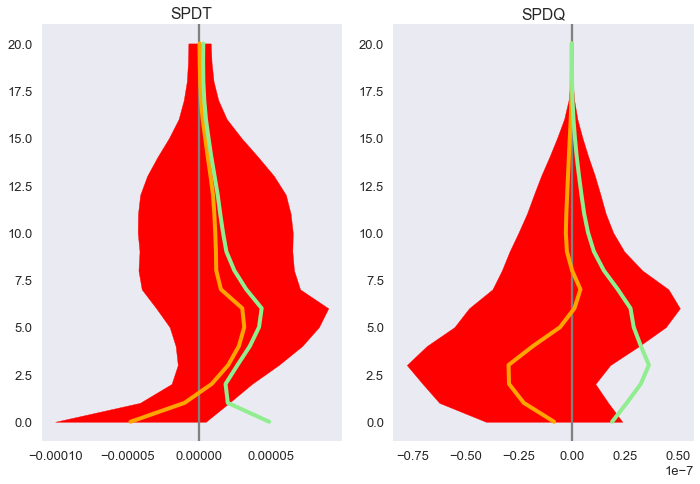

In [42]:
z = np.arange(train_out.variables['SPDT'][:].shape[0]-1, -1, -1)
fig, axes = plt.subplots(1, 2)
for i, var in enumerate([train_out.variables['SPDT'], train_out.variables['SPDQ']]):
    mean = np.mean(var[:], axis=1)
    mean_abs = np.mean(np.abs(var[:]), axis=1)
    mn = np.min(var[:], axis=1); mx = np.max(var[:], axis=1)
    std = np.std(var[:], axis=1, ddof=1)
    axes[i].set_title(var.name)
    axes[i].plot(mean, z, c='orange', lw=4)
    axes[i].plot(mean_abs, z, c='lightgreen', lw=4)
    #axes[i].fill_betweenx(z, mn, mx, zorder=0.1)
    axes[i].fill_betweenx(z, mean - std, mean + std, mx, zorder=0.15, color='r')
    axes[i].axvline(0, c='gray', zorder=0.2)
plt.tight_layout()
plt.show()

Note that the min-max range is much much larger. Next let's check out the dependency on latitude

In [43]:
lats = train_out.variables['LAT'][:]
spdt = train_out.variables['SPDT'][:]

In [44]:
lats.shape, spdt.shape

((4620288,), (21, 4620288))

In [45]:
b = binned_statistic(lats, spdt, bins=20, range=(lats.min(), lats.max()))

In [46]:
mean_lats = (b[1][1:] + b[1][:-1]) / 2.
mean_lats = ['%.0f' % l for l in mean_lats]

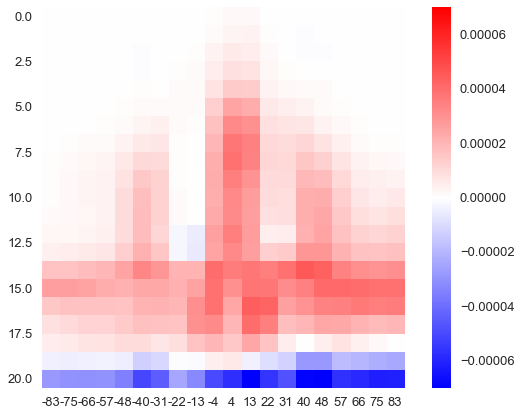

In [48]:
plt.imshow(b[0], cmap='bwr', vmin=-7e-5, vmax=7e-5)
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.show()

The ITCZ and the storm tracks are nicely visible. Let's also look at the variability

In [49]:
b = binned_statistic(lats, spdt, bins=20, statistic='std', range=(lats.min(), lats.max()))

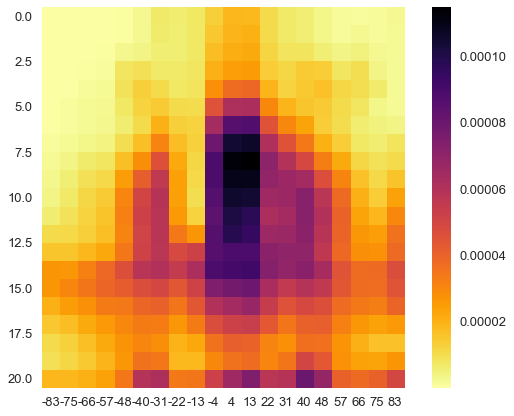

In [51]:
plt.imshow(b[0], cmap='inferno_r')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.show()

Correlates pretty well wit the means. By far the largest variability seems to be in the tropics.

Next, let's actually look at the features and targets for a few examples.

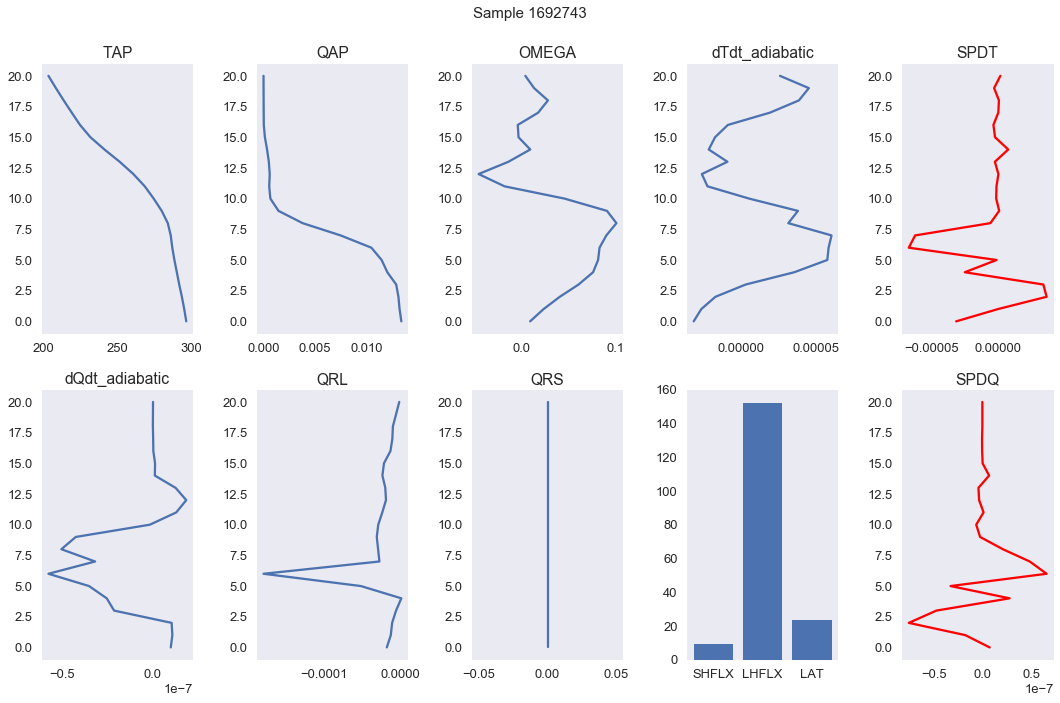

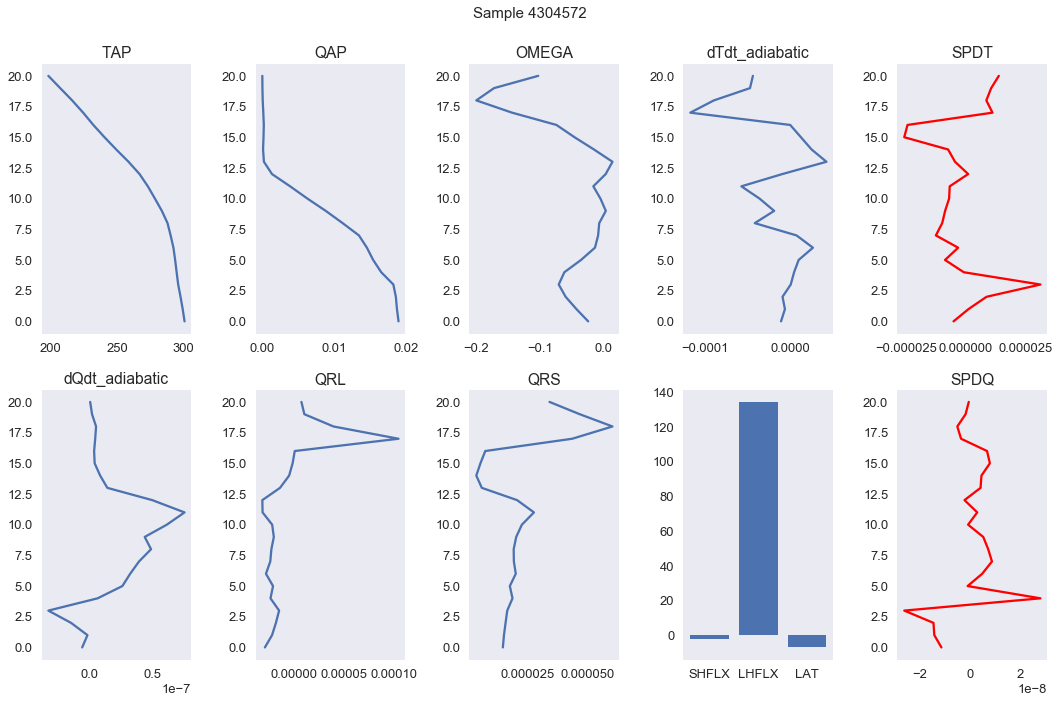

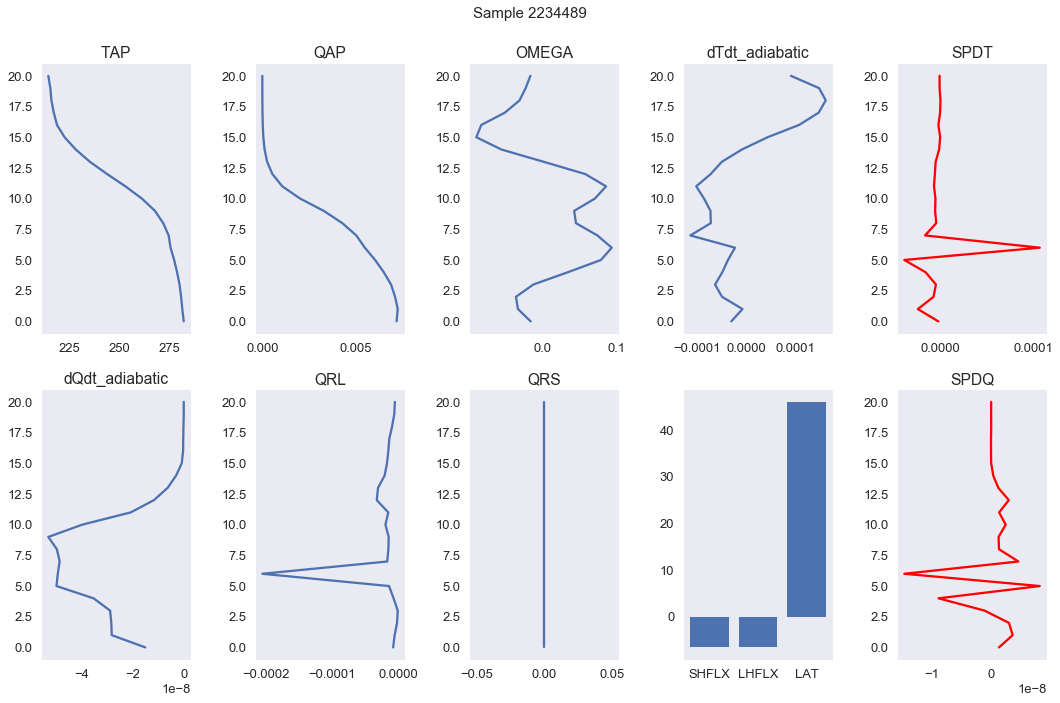

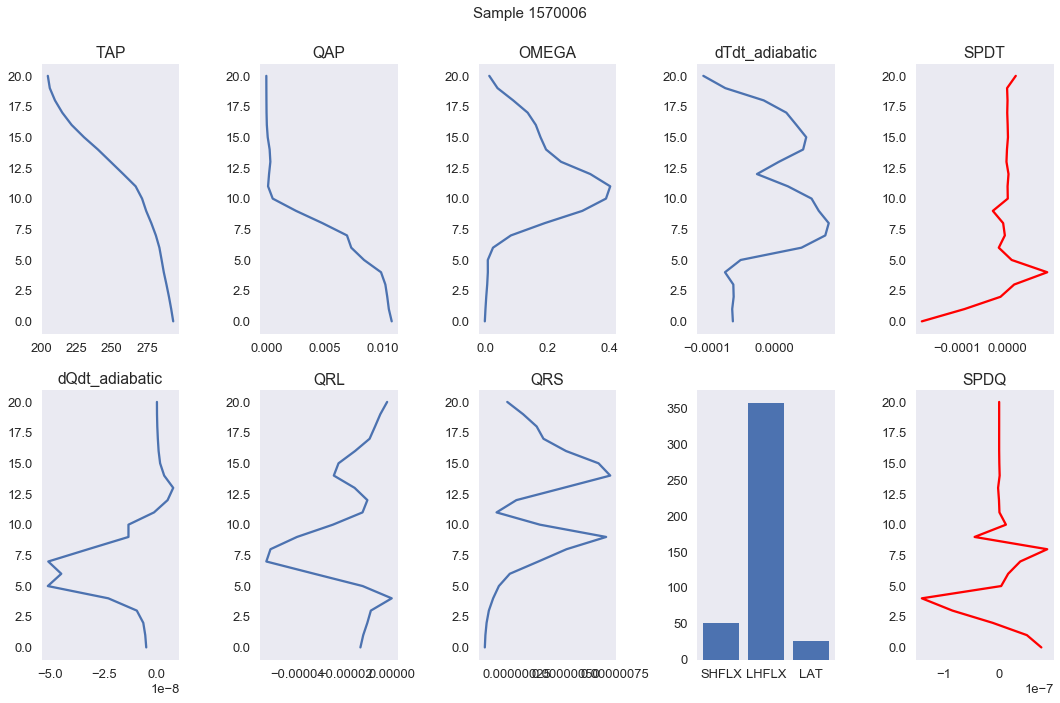

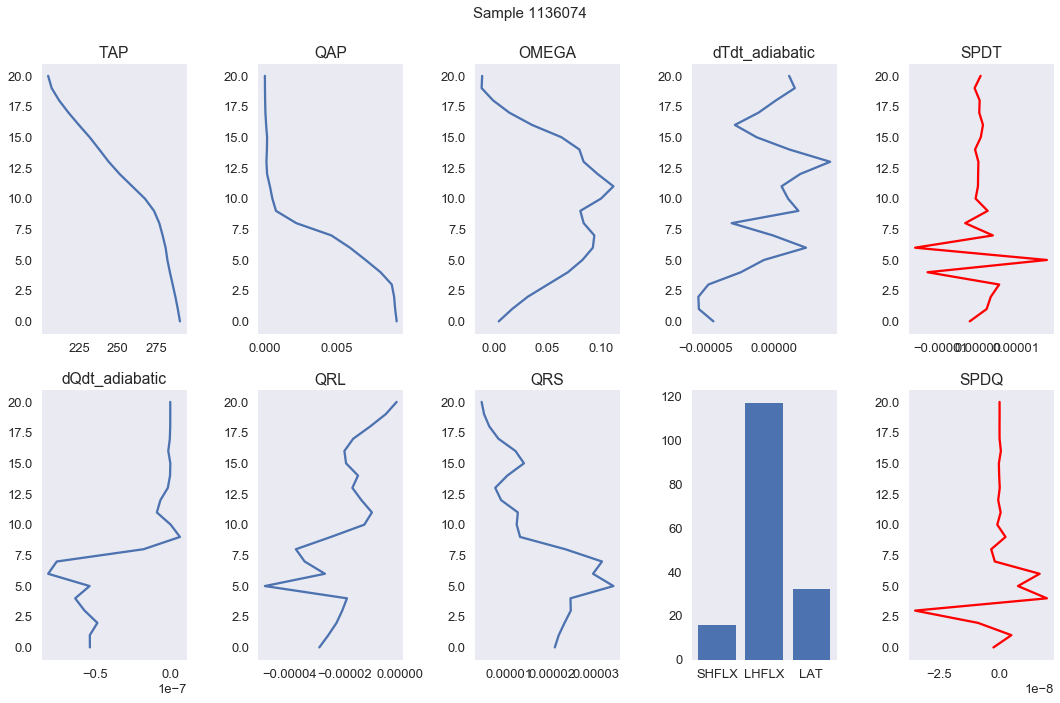

In [54]:
for i in list(np.random.randint(0, train_out.dimensions['sample'].size, 5)):
    vis_features_targets_from_nc(train_out, i, feature_vars, target_vars)

## Train Keras networks

Train Keras networks, first fully connected, then convolutional.

### Fully connected neural network
I wrote a DataGenerator class which loads and scales the features and targets. This loads the entire dataset into RAM, so for the full dataset it might be quite memory intensive!

I also split the full training set into a train and validation set by longitude.

In [38]:
train_set = DataSet(data_dir, 'SPCAM_outputs_train.nc', 'SPCAM_mean_detailed.nc',
                    'SPCAM_std_detailed.nc', feature_vars.keys())
valid_set = DataSet(data_dir, 'SPCAM_outputs_valid.nc', 'SPCAM_mean_detailed.nc',
                    'SPCAM_std_detailed.nc', feature_vars.keys())

In [6]:
train_set.features.shape, valid_set.features.shape

((3681792, 150), (938496, 150))

In [7]:
# Create model
model = fc_model(train_set.features.shape[1], train_set.targets.shape[1], [32, 32], 0.001, 'mae')

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                4832      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 42)                1386      
Total params: 7,274
Trainable params: 7,274
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(train_set.features, train_set.targets, batch_size=4096, epochs=10, 
          validation_data=(valid_set.features, valid_set.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/10
3681792/3681792 [==============================] - 7s - loss: 0.0197 - rmse: 0.0360 - log_loss: -1.5931 - total_error: 724.8891 - unexplained_error: 432.1080 - rsquared: 0.4038 - total_error_avgAx0: 630.4996 - rsquared_avgAx0: 0.3144 - val_loss: 0.0197 - val_rmse: 0.0360 - val_log_loss: -1.5944 - val_total_error: 719.9510 - val_unexplained_error: 433.6336 - val_rsquared: 0.3959 - val_total_error_avgAx0: 619.7400 - val_rsquared_avgAx0: 0.2987
Epoch 2/10
3681792/3681792 [==============================] - 7s - loss: 0.0196 - rmse: 0.0359 - log_loss: -1.5945 - total_error: 724.8960 - unexplained_error: 430.7450 - rsquared: 0.4057 - total_error_avgAx0: 630.5049 - rsquared_avgAx0: 0.3166 - val_loss: 0.0197 - val_rmse: 0.0359 - val_log_loss: -1.5955 - val_total_error: 719.9510 - val_unexplained_error: 433.4266 - val_rsquared: 0.3964 - val_total_error_avgAx0: 619.7400 - val_rsquared_avgAx0: 0.2992
Epoch 3/10
3681792/3681792 [=====

### Reproducing the results

There is something very curious going on. The network sometimes seems to get stuck at a loss of 0.0242. I am really not certain why this is happening. Let's try now running the same network again to see.

In [11]:
model = fc_model(train_set.features.shape[1], train_set.targets.shape[1], [32, 32], 0.001, 'mae')
model.fit(train_set.features, train_set.targets, batch_size=4096, epochs=20, 
          validation_data=(valid_set.features, valid_set.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/20
3681792/3681792 [==============================] - 7s - loss: 0.0313 - rmse: 0.0512 - log_loss: -1.4653 - total_error: 724.8918 - unexplained_error: 1158.2586 - rsquared: -0.5988 - total_error_avgAx0: 630.5042 - rsquared_avgAx0: -0.8390 - val_loss: 0.0240 - val_rmse: 0.0431 - val_log_loss: -1.5109 - val_total_error: 719.9510 - val_unexplained_error: 645.2071 - val_rsquared: 0.1048 - val_total_error_avgAx0: 619.7400 - val_rsquared_avgAx0: -0.0394
Epoch 2/20
3681792/3681792 [==============================] - 7s - loss: 0.0242 - rmse: 0.0434 - log_loss: -1.5066 - total_error: 724.8915 - unexplained_error: 651.2696 - rsquared: 0.1017 - total_error_avgAx0: 630.5023 - rsquared_avgAx0: -0.0329 - val_loss: 0.0240 - val_rmse: 0.0431 - val_log_loss: -1.5116 - val_total_error: 719.9510 - val_unexplained_error: 645.5694 - val_rsquared: 0.1043 - val_total_error_avgAx0: 619.7400 - val_rsquared_avgAx0: -0.0400
Epoch 3/20
3681792/3681792 

Now it happened. I am really confused by this, let's play around with the learning rate and batch size.

In [12]:
# Reduce batch size
model = fc_model(train_set.features.shape[1], train_set.targets.shape[1], [32, 32], 0.001, 'mae')
model.fit(train_set.features, train_set.targets, batch_size=512, epochs=5, 
          validation_data=(valid_set.features, valid_set.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/5
3681792/3681792 [==============================] - 26s - loss: 0.0235 - rmse: 0.0421 - log_loss: -1.5234 - total_error: 90.6214 - unexplained_error: 79.6972 - rsquared: 0.1221 - total_error_avgAx0: 78.6877 - rsquared_avgAx0: -0.0117 - val_loss: 0.0221 - val_rmse: 0.0403 - val_log_loss: -1.5381 - val_total_error: 89.9107 - val_unexplained_error: 66.7494 - val_rsquared: 0.3072 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.1135
Epoch 2/5
3681792/3681792 [==============================] - 26s - loss: 0.0221 - rmse: 0.0405 - log_loss: -1.5329 - total_error: 90.6215 - unexplained_error: 66.7661 - rsquared: 0.2614 - total_error_avgAx0: 78.6879 - rsquared_avgAx0: 0.1483 - val_loss: 0.0220 - val_rmse: 0.0403 - val_log_loss: -1.5380 - val_total_error: 89.9107 - val_unexplained_error: 67.2154 - val_rsquared: 0.3066 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.1134
Epoch 3/5
3681792/3681792 [=================

Hmm, now we seem to get stuck at a different point.

In [14]:
# Reduce learning rate
model = fc_model(train_set.features.shape[1], train_set.targets.shape[1], [32, 32], 0.0001, 'mae')
model.fit(train_set.features, train_set.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set.features, valid_set.targets),
          callbacks=[TensorBoard(log_dir='../logs/keras_fc_reference_/')])

Train on 3681792 samples, validate on 938496 samples
Epoch 1/10
3681792/3681792 [==============================] - 26s - loss: 0.0357 - rmse: 0.0563 - log_loss: -1.4432 - total_error: 90.6214 - unexplained_error: 200.4304 - rsquared: -1.2386 - total_error_avgAx0: 78.6867 - rsquared_avgAx0: -1.5832 - val_loss: 0.0240 - val_rmse: 0.0431 - val_log_loss: -1.5118 - val_total_error: 89.9107 - val_unexplained_error: 80.7097 - val_rsquared: 0.1566 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: -0.0789
Epoch 2/10
3681792/3681792 [==============================] - 26s - loss: 0.0237 - rmse: 0.0427 - log_loss: -1.5127 - total_error: 90.6214 - unexplained_error: 77.9852 - rsquared: 0.1398 - total_error_avgAx0: 78.6890 - rsquared_avgAx0: 0.0084 - val_loss: 0.0219 - val_rmse: 0.0401 - val_log_loss: -1.5397 - val_total_error: 89.9107 - val_unexplained_error: 66.2740 - val_rsquared: 0.3154 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.1255
Epoch 3/10
3681792/3681792 [===========

There we go. This seems to produce good results. 

### Keras  vs. random vs. by-lon train/valid split

Does it make a difference whether we are splitting the train and validation set randomly or by longitude?

In [15]:
full_set = DataSet(data_dir, 'SPCAM_outputs_detailed.nc', 'SPCAM_mean_detailed.nc',
                   'SPCAM_std_detailed.nc', feature_vars.keys())

In [16]:
model = fc_model(full_set.features.shape[1], full_set.targets.shape[1], [32, 32], 0.0001, 'mae')
model.fit(full_set.features, full_set.targets, batch_size=512, epochs=10, validation_split=0.2)

Train on 3696230 samples, validate on 924058 samples
Epoch 1/10
3696230/3696230 [==============================] - 27s - loss: 0.0375 - rmse: 0.0580 - log_loss: -1.4424 - total_error: 90.9904 - unexplained_error: 228.9636 - rsquared: -1.5204 - total_error_avgAx0: 79.0810 - rsquared_avgAx0: -1.9019 - val_loss: 0.0223 - val_rmse: 0.0406 - val_log_loss: -1.5310 - val_total_error: 88.3705 - val_unexplained_error: 66.8797 - val_rsquared: 0.3210 - val_total_error_avgAx0: 70.2434 - val_rsquared_avgAx0: 0.0664
Epoch 2/10
3696230/3696230 [==============================] - 26s - loss: 0.0217 - rmse: 0.0397 - log_loss: -1.5403 - total_error: 90.9909 - unexplained_error: 64.0683 - rsquared: 0.2943 - total_error_avgAx0: 79.0812 - rsquared_avgAx0: 0.1870 - val_loss: 0.0204 - val_rmse: 0.0373 - val_log_loss: -1.5593 - val_total_error: 88.3705 - val_unexplained_error: 53.3686 - val_rsquared: 0.4175 - val_total_error_avgAx0: 70.2434 - val_rsquared_avgAx0: 0.1941
Epoch 3/10
3696230/3696230 [============

It seems we can get better scores with a random train_valid split. Note that in keras the train valid split is computed before the data is shuffled, once for all epochs. Since the features are structured, I am not sure what this really means. Are we cheating somehow? Would the results be different if we split the data randomly ourselves? 

For this we can just load the randomly split data I generated a while ago.

In [18]:
train_set_rand = DataSet(data_dir_old, 'SPCAM_outputs_train.nc', 'SPCAM_mean_detailed.nc',
                         'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                         mean_std_dir=data_dir)
valid_set_rand = DataSet(data_dir_old, 'SPCAM_outputs_valid.nc', 'SPCAM_mean_detailed.nc',
                         'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                         mean_std_dir=data_dir)

In [19]:
model = fc_model(train_set_rand.features.shape[1], train_set_rand.targets.shape[1], [32, 32], 
                 0.0001, 'mae')
model.fit(train_set_rand.features, train_set_rand.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set_rand.features, valid_set_rand.targets))

Train on 3696230 samples, validate on 924058 samples
Epoch 1/10
3696230/3696230 [==============================] - 34s - loss: 0.0345 - rmse: 0.0547 - log_loss: -1.4559 - total_error: 90.5255 - unexplained_error: 181.1546 - rsquared: -1.0151 - total_error_avgAx0: 78.5517 - rsquared_avgAx0: -1.3244 - val_loss: 0.0219 - val_rmse: 0.0402 - val_log_loss: -1.5353 - val_total_error: 90.3822 - val_unexplained_error: 65.7891 - val_rsquared: 0.2700 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.1579
Epoch 2/10
3696230/3696230 [==============================] - 34s - loss: 0.0207 - rmse: 0.0382 - log_loss: -1.5637 - total_error: 90.5250 - unexplained_error: 60.0590 - rsquared: 0.3351 - total_error_avgAx0: 78.5511 - rsquared_avgAx0: 0.2328 - val_loss: 0.0200 - val_rmse: 0.0370 - val_log_loss: -1.5781 - val_total_error: 90.3822 - val_unexplained_error: 55.9959 - val_rsquared: 0.3789 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.2836
Epoch 3/10
3696230/3696230 [============

Somewhere in-between. It seems like the train/valid split problem is something we should solve properly just using another year for validation! For now I will use the split by lon, since it will help me with the visualization later on.

### The best possible (but reasonable) fully connected network

How good can we get with a reasonably sized fully connected network?

#### Train/valid split by lon

In [20]:
model = fc_model(train_set.features.shape[1], train_set.targets.shape[1], [200, 200, 200], 0.0001, 'mae')
print(model.summary())
model.fit(train_set.features, train_set.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set.features, valid_set.targets))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 200)               30200     
_________________________________________________________________
dense_23 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_24 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_25 (Dense)             (None, 42)                8442      
Total params: 119,042
Trainable params: 119,042
Non-trainable params: 0
_________________________________________________________________
None
Train on 3681792 samples, validate on 938496 samples
Epoch 1/10
3681792/3681792 [==============================] - 33s - loss: 0.0226 - rmse: 0.0401 - log_loss: -1.5475 - total_error: 90.6215 - unexplained_error: 70.1461 - rsquared: 0.2220 - total_error_avgAx0: 7

In [25]:
model = fc_model(train_set.features.shape[1], train_set.targets.shape[1], [1024, 1024, 512, 512], 
                 0.0001, 'mae')

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1024)              154624    
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_33 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_35 (Dense)             (None, 42)                21546     
Total params: 2,013,226
Trainable params: 2,013,226
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(train_set.features, train_set.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set.features, valid_set.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/10
3681792/3681792 [==============================] - 117s - loss: 0.0169 - rmse: 0.0307 - log_loss: -1.6742 - total_error: 90.6215 - unexplained_error: 41.4291 - rsquared: 0.5426 - total_error_avgAx0: 78.6883 - rsquared_avgAx0: 0.4726 - val_loss: 0.0157 - val_rmse: 0.0287 - val_log_loss: -1.7109 - val_total_error: 89.9107 - val_unexplained_error: 37.3557 - val_rsquared: 0.6353 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.5383
Epoch 2/10
3681792/3681792 [==============================] - 116s - loss: 0.0153 - rmse: 0.0280 - log_loss: -1.7234 - total_error: 90.6215 - unexplained_error: 35.9043 - rsquared: 0.6035 - total_error_avgAx0: 78.6869 - rsquared_avgAx0: 0.5428 - val_loss: 0.0153 - val_rmse: 0.0279 - val_log_loss: -1.7267 - val_total_error: 89.9107 - val_unexplained_error: 35.7196 - val_rsquared: 0.6542 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.5625
Epoch 3/10
3681792/3681792 [=============

In [31]:
model.optimizer.lr = tf.Variable(1e-5)

In [32]:
model.fit(train_set.features, train_set.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set.features, valid_set.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/10
3681792/3681792 [==============================] - 117s - loss: 0.0141 - rmse: 0.0261 - log_loss: -1.7636 - total_error: 90.6214 - unexplained_error: 31.3642 - rsquared: 0.6532 - total_error_avgAx0: 78.6869 - rsquared_avgAx0: 0.6001 - val_loss: 0.0146 - val_rmse: 0.0269 - val_log_loss: -1.7489 - val_total_error: 89.9107 - val_unexplained_error: 33.3272 - val_rsquared: 0.6797 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.5951
Epoch 2/10
3681792/3681792 [==============================] - 117s - loss: 0.0141 - rmse: 0.0260 - log_loss: -1.7650 - total_error: 90.6214 - unexplained_error: 31.1220 - rsquared: 0.6559 - total_error_avgAx0: 78.6883 - rsquared_avgAx0: 0.6032 - val_loss: 0.0146 - val_rmse: 0.0268 - val_log_loss: -1.7502 - val_total_error: 89.9107 - val_unexplained_error: 33.2550 - val_rsquared: 0.6815 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.5976
Epoch 3/10
3681792/3681792 [=============

#### Random train valid split with old mean/std

Ok, so this is very good. Let's take the random split with the original mean_std to get a sanity check.

In [33]:
train_set_rand_old = DataSet(data_dir_old, 'SPCAM_outputs_train.nc', 'SPCAM_mean.nc',
                         'SPCAM_std.nc', feature_vars.keys(), flat_input=True)
valid_set_rand_old = DataSet(data_dir_old, 'SPCAM_outputs_valid.nc', 'SPCAM_mean.nc',
                         'SPCAM_std.nc', feature_vars.keys(), flat_input=True)

In [34]:
model = fc_model(train_set_rand_old.features.shape[1], train_set_rand_old.targets.shape[1], 
                 [1024, 1024, 512, 512], 0.0001, 'mae')

In [35]:
model.fit(train_set_rand_old.features, train_set_rand_old.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set_rand_old.features, valid_set_rand_old.targets))

Train on 3696230 samples, validate on 924058 samples
Epoch 1/10
3696230/3696230 [==============================] - 125s - loss: 0.0202 - rmse: 0.0341 - log_loss: -1.6106 - total_error: 90.5256 - unexplained_error: 55.2162 - rsquared: 0.3909 - total_error_avgAx0: 78.5493 - rsquared_avgAx0: 0.2983 - val_loss: 0.0160 - val_rmse: 0.0292 - val_log_loss: -1.6870 - val_total_error: 90.3822 - val_unexplained_error: 36.5449 - val_rsquared: 0.5948 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5326
Epoch 2/10
3696230/3696230 [==============================] - 125s - loss: 0.0156 - rmse: 0.0286 - log_loss: -1.6972 - total_error: 90.5254 - unexplained_error: 35.3711 - rsquared: 0.6085 - total_error_avgAx0: 78.5518 - rsquared_avgAx0: 0.5483 - val_loss: 0.0154 - val_rmse: 0.0282 - val_log_loss: -1.7066 - val_total_error: 90.3822 - val_unexplained_error: 34.9039 - val_rsquared: 0.6132 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5539
Epoch 3/10
3696230/3696230 [=============

In [36]:
model.optimizer.lr = tf.Variable(1e-5)

In [37]:
model.fit(train_set_rand_old.features, train_set_rand_old.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set_rand_old.features, valid_set_rand_old.targets))

Train on 3696230 samples, validate on 924058 samples
Epoch 1/10
3696230/3696230 [==============================] - 125s - loss: 0.0142 - rmse: 0.0261 - log_loss: -1.7550 - total_error: 90.5249 - unexplained_error: 30.3827 - rsquared: 0.6634 - total_error_avgAx0: 78.5521 - rsquared_avgAx0: 0.6116 - val_loss: 0.0144 - val_rmse: 0.0264 - val_log_loss: -1.7518 - val_total_error: 90.3822 - val_unexplained_error: 31.5860 - val_rsquared: 0.6498 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5960
Epoch 2/10
3696230/3696230 [==============================] - 125s - loss: 0.0141 - rmse: 0.0260 - log_loss: -1.7565 - total_error: 90.5243 - unexplained_error: 30.1463 - rsquared: 0.6659 - total_error_avgAx0: 78.5509 - rsquared_avgAx0: 0.6145 - val_loss: 0.0143 - val_rmse: 0.0263 - val_log_loss: -1.7529 - val_total_error: 90.3822 - val_unexplained_error: 31.3433 - val_rsquared: 0.6523 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5989
Epoch 3/10
3696230/3696230 [=============

So these results are pretty good, but there are some points to explore further:
- There is some overfitting: Train scores are further decreasing while valid score are constant or even increasing.
- The train/valid differences between the datasets are really curious. I am not sure why this is? Maybe my sample size is simply not enough and by splitting by longitude I get some randomness.

#### Random train valid split with new mean/std

To get a comparison with the TF run, which uses almost the same data I hope.

In [7]:
train_set_rand = DataSet(data_dir_old, 'SPCAM_outputs_train.nc', 'SPCAM_mean_detailed.nc',
                         'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                         mean_std_dir=data_dir)
valid_set_rand = DataSet(data_dir_old, 'SPCAM_outputs_valid.nc', 'SPCAM_mean_detailed.nc',
                         'SPCAM_std_detailed.nc', feature_vars.keys(), flat_input=True,
                         mean_std_dir=data_dir)

In [8]:
model = fc_model(train_set_rand.features.shape[1], train_set_rand.targets.shape[1], 
                 [1024, 1024, 512, 512], 0.0001, 'mae')

In [9]:
model.fit(train_set_rand.features, train_set_rand.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set_rand.features, valid_set_rand.targets),
          callbacks=[TensorBoard(log_dir='../logs/quite-complex_fc/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/10
3696230/3696230 [==============================] - 216s - loss: 0.0169 - rmse: 0.0305 - log_loss: -1.6795 - total_error: 90.5245 - unexplained_error: 41.4130 - rsquared: 0.5417 - total_error_avgAx0: 78.5518 - rsquared_avgAx0: 0.4713 - val_loss: 0.0154 - val_rmse: 0.0284 - val_log_loss: -1.7167 - val_total_error: 90.3822 - val_unexplained_error: 36.4273 - val_rsquared: 0.5963 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5343
Epoch 2/10
3696230/3696230 [==============================] - 216s - loss: 0.0152 - rmse: 0.0279 - log_loss: -1.7268 - total_error: 90.5258 - unexplained_error: 35.7463 - rsquared: 0.6048 - total_error_avgAx0: 78.5541 - rsquared_avgAx0: 0.5440 - val_loss: 0.0150 - val_rmse: 0.0276 - val_log_loss: -1.7334 - val_total_error: 90.3822 - val_unexplained_error: 35.1072 - val_rsquared: 0.6111 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5514
Epoch 3/10
3696230/3696230 [=============

In [10]:
model.optimizer.lr = tf.Variable(1e-5)

In [11]:
model.fit(train_set_rand.features, train_set_rand.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set_rand.features, valid_set_rand.targets),
          callbacks=[TensorBoard(log_dir='../logs/quite-complex_fc/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/10
3696230/3696230 [==============================] - 215s - loss: 0.0141 - rmse: 0.0260 - log_loss: -1.7649 - total_error: 90.5248 - unexplained_error: 31.3860 - rsquared: 0.6526 - total_error_avgAx0: 78.5517 - rsquared_avgAx0: 0.5991 - val_loss: 0.0143 - val_rmse: 0.0263 - val_log_loss: -1.7606 - val_total_error: 90.3822 - val_unexplained_error: 32.0981 - val_rsquared: 0.6442 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5896
Epoch 2/10
3696230/3696230 [==============================] - 216s - loss: 0.0141 - rmse: 0.0260 - log_loss: -1.7662 - total_error: 90.5246 - unexplained_error: 31.1628 - rsquared: 0.6550 - total_error_avgAx0: 78.5522 - rsquared_avgAx0: 0.6019 - val_loss: 0.0143 - val_rmse: 0.0263 - val_log_loss: -1.7627 - val_total_error: 90.3822 - val_unexplained_error: 32.1899 - val_rsquared: 0.6428 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5879
Epoch 3/10
3696230/3696230 [=============

In [12]:
model.optimizer.lr = tf.Variable(1e-6)

In [13]:
model.fit(train_set_rand.features, train_set_rand.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set_rand.features, valid_set_rand.targets),
          callbacks=[TensorBoard(log_dir='../logs/quite-complex_fc/')])

Train on 3696230 samples, validate on 924058 samples
Epoch 1/10
3696230/3696230 [==============================] - 216s - loss: 0.0138 - rmse: 0.0255 - log_loss: -1.7737 - total_error: 90.5255 - unexplained_error: 29.6161 - rsquared: 0.6718 - total_error_avgAx0: 78.5514 - rsquared_avgAx0: 0.6213 - val_loss: 0.0142 - val_rmse: 0.0261 - val_log_loss: -1.7677 - val_total_error: 90.3822 - val_unexplained_error: 31.9073 - val_rsquared: 0.6464 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5921
Epoch 2/10
3696230/3696230 [==============================] - 216s - loss: 0.0138 - rmse: 0.0254 - log_loss: -1.7743 - total_error: 90.5243 - unexplained_error: 29.4727 - rsquared: 0.6734 - total_error_avgAx0: 78.5501 - rsquared_avgAx0: 0.6231 - val_loss: 0.0141 - val_rmse: 0.0260 - val_log_loss: -1.7679 - val_total_error: 90.3822 - val_unexplained_error: 31.8646 - val_rsquared: 0.6471 - val_total_error_avgAx0: 78.4426 - val_rsquared_avgAx0: 0.5929
Epoch 3/10
3696230/3696230 [=============

#### With tanh activation

In [39]:
model = fc_model(train_set.features.shape[1], train_set.targets.shape[1], [1024, 1024, 512, 512], 
                 0.0001, 'mae', activation='tanh')

In [40]:
model.fit(train_set.features, train_set.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set.features, valid_set.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/10
3681792/3681792 [==============================] - 155s - loss: 0.0221 - rmse: 0.0356 - log_loss: -1.5876 - total_error: 90.6215 - unexplained_error: 53.2445 - rsquared: 0.4123 - total_error_avgAx0: 78.6887 - rsquared_avgAx0: 0.3225 - val_loss: 0.0178 - val_rmse: 0.0316 - val_log_loss: -1.6444 - val_total_error: 89.9107 - val_unexplained_error: 43.0729 - val_rsquared: 0.5652 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.4478
Epoch 2/10
3681792/3681792 [==============================] - 155s - loss: 0.0171 - rmse: 0.0307 - log_loss: -1.6607 - total_error: 90.6215 - unexplained_error: 41.0660 - rsquared: 0.5468 - total_error_avgAx0: 78.6887 - rsquared_avgAx0: 0.4775 - val_loss: 0.0165 - val_rmse: 0.0299 - val_log_loss: -1.6787 - val_total_error: 89.9107 - val_unexplained_error: 39.6256 - val_rsquared: 0.6076 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.5026
Epoch 3/10
3681792/3681792 [=============

KeyboardInterrupt: 

In [ ]:
model.optimizer.lr = tf.Variable(1e-5)
model.fit(train_set.features, train_set.targets, batch_size=512, epochs=10, 
          validation_data=(valid_set.features, valid_set.targets))

### Convolutional neural network

Let's build a convolutional neural net inputting the 2D variables (sample, lev) as features.

In [14]:
train_set_cov = DataSet(data_dir, 'SPCAM_outputs_train.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), convolution=True)
valid_set_cov = DataSet(data_dir, 'SPCAM_outputs_valid.nc', 'SPCAM_mean_detailed.nc',
                        'SPCAM_std_detailed.nc', feature_vars.keys(), convolution=True)

In [16]:
train_set_cov.features[0].shape

(3681792, 21, 7)

In [18]:
model = conv_model(train_set_cov.features[0].shape[1:], train_set_cov.features[1].shape[1],
                   train_set_cov.targets.shape[1], [32, 32], [100], 1e-3, 'mae')

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 21, 7)         0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 21, 32)        704         input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 21, 32)        3104        conv1d_1[0][0]                   
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 672)           0           conv1d_2[0][0]                   
___________________________________________________________________________________________

In [20]:
model.fit(train_set_cov.features, train_set_cov.targets, batch_size=128, epochs=5, 
          validation_data=(valid_set_cov.features, valid_set_cov.targets),
          callbacks=[TensorBoard(log_dir='../logs/simple_cnn/')])

Train on 3681792 samples, validate on 938496 samples
Epoch 1/5
3681792/3681792 [==============================] - 196s - loss: 0.0187 - rmse: 0.0345 - log_loss: -1.6065 - total_error: 22.6543 - unexplained_error: 12.2553 - rsquared: 0.4550 - total_error_avgAx0: 19.5554 - rsquared_avgAx0: 0.3662 - val_loss: 0.0185 - val_rmse: 0.0339 - val_log_loss: -1.6158 - val_total_error: 22.4602 - val_unexplained_error: 11.9233 - val_rsquared: 0.5049 - val_total_error_avgAx0: 17.4365 - val_rsquared_avgAx0: 0.2824
Epoch 2/5
 180096/3681792 [>.............................] - ETA: 169s - loss: 0.0184 - rmse: 0.0339 - log_loss: -1.6144 - total_error: 22.5419 - unexplained_error: 11.8316 - rsquared: 0.4714 - total_error_avgAx0: 19.4729 - rsquared_avgAx0: 0.3856

KeyboardInterrupt: 

In [21]:
model.optimizer.lr = tf.Variable(1e-4)
model.fit(train_set_cov.features, train_set_cov.targets, batch_size=512, epochs=1, 
          validation_data=(valid_set_cov.features, valid_set_cov.targets),
          callbacks=[TensorBoard(log_dir='../logs/simple_cnn/')])

Train on 3681792 samples, validate on 938496 samples
Epoch 1/1
3681792/3681792 [==============================] - 67s - loss: 0.0183 - rmse: 0.0337 - log_loss: -1.6176 - total_error: 90.6215 - unexplained_error: 46.8019 - rsquared: 0.4826 - total_error_avgAx0: 78.6880 - rsquared_avgAx0: 0.4035 - val_loss: 0.0183 - val_rmse: 0.0337 - val_log_loss: -1.6198 - val_total_error: 89.9107 - val_unexplained_error: 46.9398 - val_rsquared: 0.5147 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.3804


In [22]:
model.optimizer.lr = tf.Variable(1e-4)
model.fit(train_set_cov.features, train_set_cov.targets, batch_size=128, epochs=3, 
          validation_data=(valid_set_cov.features, valid_set_cov.targets),
          callbacks=[TensorBoard(log_dir='../logs/simple_cnn/')])

Train on 3681792 samples, validate on 938496 samples
Epoch 1/3
3681792/3681792 [==============================] - 195s - loss: 0.0184 - rmse: 0.0338 - log_loss: -1.6161 - total_error: 22.6542 - unexplained_error: 11.7816 - rsquared: 0.4763 - total_error_avgAx0: 19.5564 - rsquared_avgAx0: 0.3909 - val_loss: 0.0184 - val_rmse: 0.0337 - val_log_loss: -1.6192 - val_total_error: 22.4602 - val_unexplained_error: 11.7994 - val_rsquared: 0.5110 - val_total_error_avgAx0: 17.4365 - val_rsquared_avgAx0: 0.2913
Epoch 2/3
3681792/3681792 [==============================] - 196s - loss: 0.0183 - rmse: 0.0337 - log_loss: -1.6169 - total_error: 22.6543 - unexplained_error: 11.7303 - rsquared: 0.4785 - total_error_avgAx0: 19.5571 - rsquared_avgAx0: 0.3935 - val_loss: 0.0184 - val_rmse: 0.0337 - val_log_loss: -1.6185 - val_total_error: 22.4602 - val_unexplained_error: 11.8102 - val_rsquared: 0.5087 - val_total_error_avgAx0: 17.4365 - val_rsquared_avgAx0: 0.2869
Epoch 3/3
3681792/3681792 [================

### A more complex CNN

Test some different architectures.

In [26]:
# Different activation function
model = conv_model(train_set_cov.features[0].shape[1:], train_set_cov.features[1].shape[1],
                   train_set_cov.targets.shape[1], [32, 32], [100], 1e-3, 'mae', 
                   activation='tanh')

In [28]:
model.optimizer.lr = 1e-4
model.fit(train_set_cov.features, train_set_cov.targets, batch_size=512, epochs=1, 
          validation_data=(valid_set_cov.features, valid_set_cov.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/1
3681792/3681792 [==============================] - 68s - loss: 0.0172 - rmse: 0.0312 - log_loss: -1.6563 - total_error: 90.6215 - unexplained_error: 42.7328 - rsquared: 0.5285 - total_error_avgAx0: 78.6879 - rsquared_avgAx0: 0.4565 - val_loss: 0.0170 - val_rmse: 0.0306 - val_log_loss: -1.6684 - val_total_error: 89.9107 - val_unexplained_error: 42.0726 - val_rsquared: 0.5828 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.4716


Ah, interesting, using tanh instead of relu gives us an improved score. We should try that for the fully connected net!

In [29]:
# Larger kernel
model = conv_model(train_set_cov.features[0].shape[1:], train_set_cov.features[1].shape[1],
                   train_set_cov.targets.shape[1], [32, 32], [100], 1e-3, 'mae', 
                   activation='tanh', kernel_size=5)

In [30]:
model.fit(train_set_cov.features, train_set_cov.targets, batch_size=512, epochs=1, 
          validation_data=(valid_set_cov.features, valid_set_cov.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/1
3681792/3681792 [==============================] - 73s - loss: 0.0182 - rmse: 0.0327 - log_loss: -1.6344 - total_error: 90.6214 - unexplained_error: 46.2868 - rsquared: 0.4889 - total_error_avgAx0: 78.6855 - rsquared_avgAx0: 0.4108 - val_loss: 0.0175 - val_rmse: 0.0316 - val_log_loss: -1.6547 - val_total_error: 89.9107 - val_unexplained_error: 44.2856 - val_rsquared: 0.5598 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.4421


In [31]:
model.optimizer.lr = 1e-4
model.fit(train_set_cov.features, train_set_cov.targets, batch_size=512, epochs=1, 
          validation_data=(valid_set_cov.features, valid_set_cov.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/1
3681792/3681792 [==============================] - 72s - loss: 0.0173 - rmse: 0.0313 - log_loss: -1.6554 - total_error: 90.6215 - unexplained_error: 43.1336 - rsquared: 0.5242 - total_error_avgAx0: 78.6889 - rsquared_avgAx0: 0.4515 - val_loss: 0.0171 - val_rmse: 0.0308 - val_log_loss: -1.6663 - val_total_error: 89.9107 - val_unexplained_error: 42.8222 - val_rsquared: 0.5777 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.4654


Not a lot of difference. Actually, the validation score is slightly lower.

In [32]:
# Adding dense layers
model = conv_model(train_set_cov.features[0].shape[1:], train_set_cov.features[1].shape[1],
                   train_set_cov.targets.shape[1], [32, 32], [1024, 512], 1e-3, 'mae', 
                   activation='tanh')

In [33]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 21, 7)         0                                            
____________________________________________________________________________________________________
conv1d_9 (Conv1D)                (None, 21, 32)        704         input_9[0][0]                    
____________________________________________________________________________________________________
conv1d_10 (Conv1D)               (None, 21, 32)        3104        conv1d_9[0][0]                   
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 672)           0           conv1d_10[0][0]                  
___________________________________________________________________________________________

In [34]:
model.fit(train_set_cov.features, train_set_cov.targets, batch_size=512, epochs=1, 
          validation_data=(valid_set_cov.features, valid_set_cov.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/1
3681792/3681792 [==============================] - 142s - loss: 0.0181 - rmse: 0.0322 - log_loss: -1.6400 - total_error: 90.6215 - unexplained_error: 44.8672 - rsquared: 0.5049 - total_error_avgAx0: 78.6872 - rsquared_avgAx0: 0.4293 - val_loss: 0.0171 - val_rmse: 0.0309 - val_log_loss: -1.6656 - val_total_error: 89.9107 - val_unexplained_error: 42.5470 - val_rsquared: 0.5790 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.4669


In [35]:
model.optimizer.lr = 1e-4
model.fit(train_set_cov.features, train_set_cov.targets, batch_size=512, epochs=1, 
          validation_data=(valid_set_cov.features, valid_set_cov.targets))

Train on 3681792 samples, validate on 938496 samples
Epoch 1/1
3681792/3681792 [==============================] - 141s - loss: 0.0169 - rmse: 0.0305 - log_loss: -1.6666 - total_error: 90.6215 - unexplained_error: 41.2985 - rsquared: 0.5444 - total_error_avgAx0: 78.6883 - rsquared_avgAx0: 0.4749 - val_loss: 0.0167 - val_rmse: 0.0300 - val_log_loss: -1.6795 - val_total_error: 89.9107 - val_unexplained_error: 40.1899 - val_rsquared: 0.6024 - val_total_error_avgAx0: 74.2182 - val_rsquared_avgAx0: 0.4963


## Visualize predictions

In [5]:
from keras.utils.generic_utils import get_custom_objects

In [6]:
metrics_dict = dict([(f.__name__, f) for f in metrics])

In [7]:
metrics_dict

{'log_loss': <function losses.log_loss>,
 'rmse': <function losses.rmse>,
 'rsquared': <function losses.rsquared>,
 'rsquared_avgAx0': <function losses.rsquared_avgAx0>,
 'total_error': <function losses.total_error>,
 'total_error_avgAx0': <function losses.total_error_avgAx0>,
 'unexplained_error': <function losses.unexplained_error>}

In [8]:
get_custom_objects().update(metrics_dict)

In [9]:
model = keras.models.load_model('/home/s/S.Rasp/repositories/CBRAIN/models/complex_cnn2.h5')

In [53]:
preds = model.predict(valid_set.features, batch_size=4096)

In [17]:
preds.shape

(924058, 42)

In [18]:
valid_set.targets.shape

(924058, 42)

In [20]:
valid_set.features[0].shape, valid_set.features[1].shape

((924058, 21, 7), (924058, 3))

In [29]:
a = valid_set.feature_names

<function odict_keys.isdisjoint>

In [23]:
valid_set.target_names

['SPDT', 'SPDQ']

In [36]:
i = 900000

In [37]:
preds.min(), preds.max()

(-2.0539122, 1.9880196)

In [51]:
def plot_stuff(features_2d, features_1d, targets, predictions, sample_idx, 
               feature_names, target_names):
    z = np.arange(20, -1, -1)
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    in_axes = np.ravel(axes[:, :4])
    out_axes = np.ravel(axes[:, 4])
    
    for i in range(features_2d.shape[-1]):
        in_axes[i].plot(features_2d[sample_idx, :, i], z)
        in_axes[i].set_title(feature_names[i])
    in_axes[-1].bar(range(features_1d.shape[1]), features_1d[sample_idx, :], 
                    tick_label=feature_names[-3:])
    
    # Split targets
    t = targets.reshape((targets.shape[0], -1, 2))
    p = predictions.reshape((predictions.shape[0], -1, 2))
    for i in range(t.shape[-1]):
        out_axes[i].plot(t[sample_idx, :, i], z, label='True')
        out_axes[i].plot(p[sample_idx, :, i], z, label='Prediction')
        out_axes[i].set_xlim(-0.5, 0.5)
        out_axes[i].set_title(target_names[i])
        out_axes[i].axvline(0, c='gray', zorder=0.1)
    out_axes[-1].legend(loc=0)
    plt.suptitle('Sample %i' % sample_idx, fontsize=15)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()

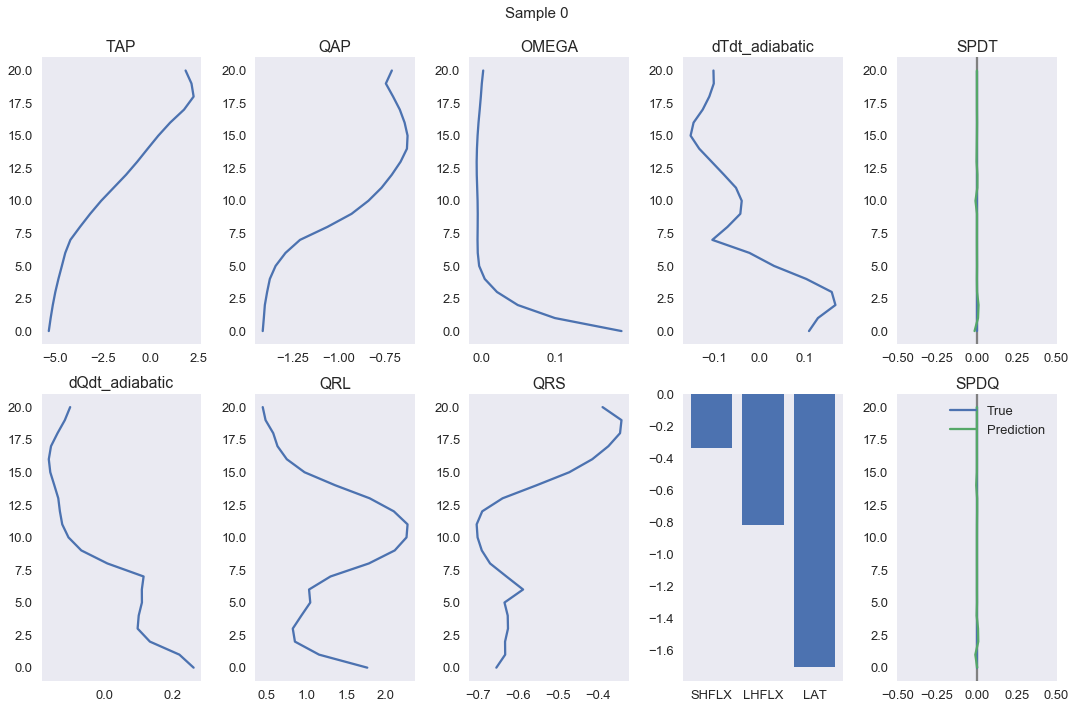

In [55]:
plot_stuff(valid_set.features[0], valid_set.features[1], valid_set.targets, preds,
               0, list(valid_set.feature_names), valid_set.target_names)

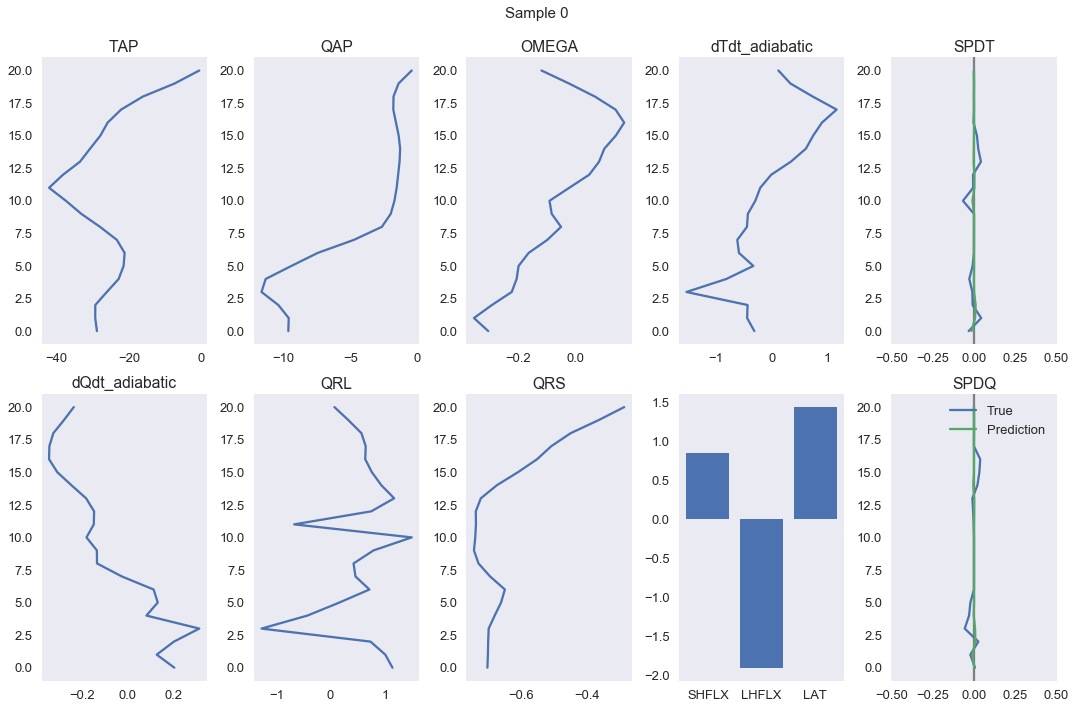

In [56]:
plot_stuff(valid_set_old.features[0], valid_set_old.features[1], valid_set_old.targets, preds,
               0, list(valid_set_old.feature_names), valid_set_old.target_names)

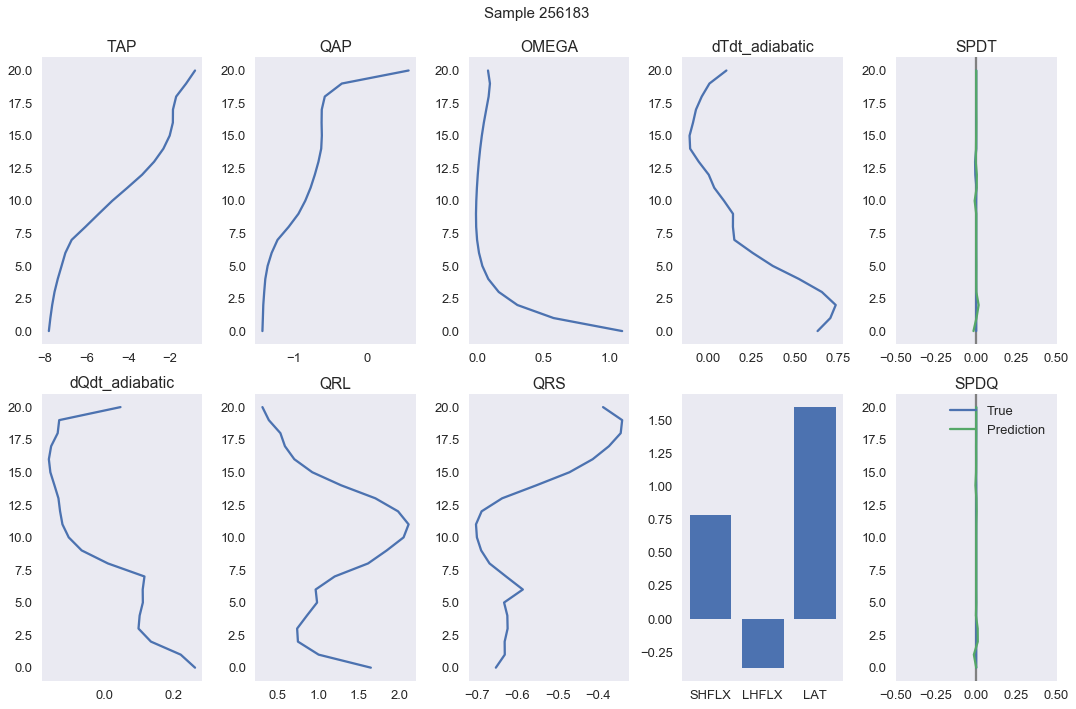

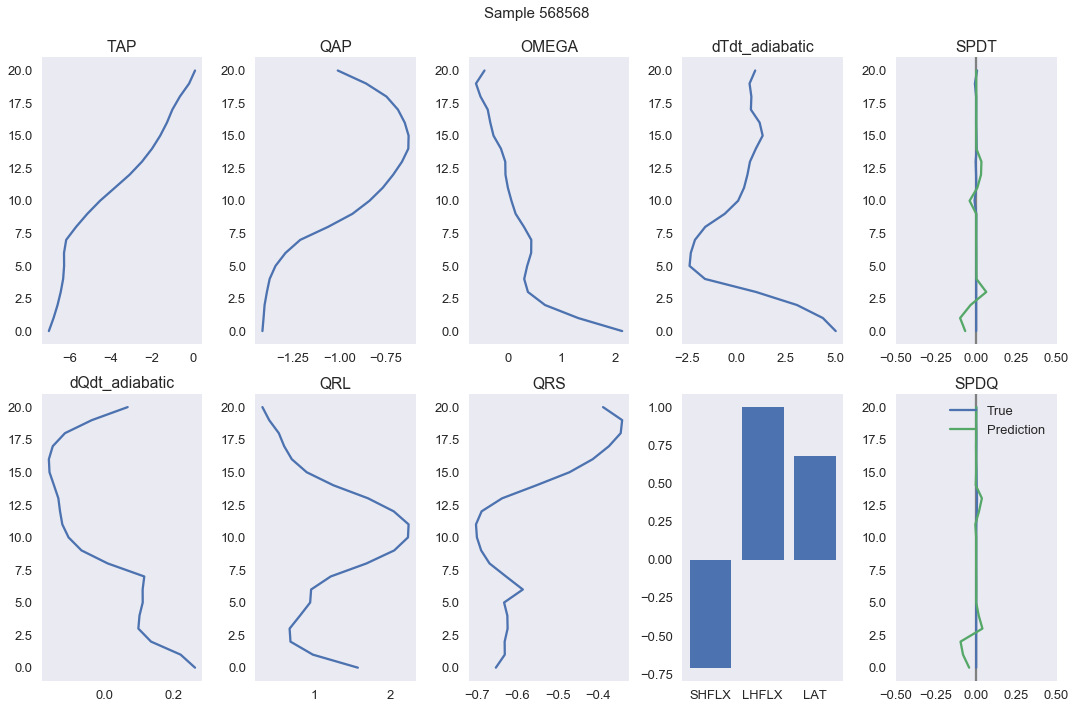

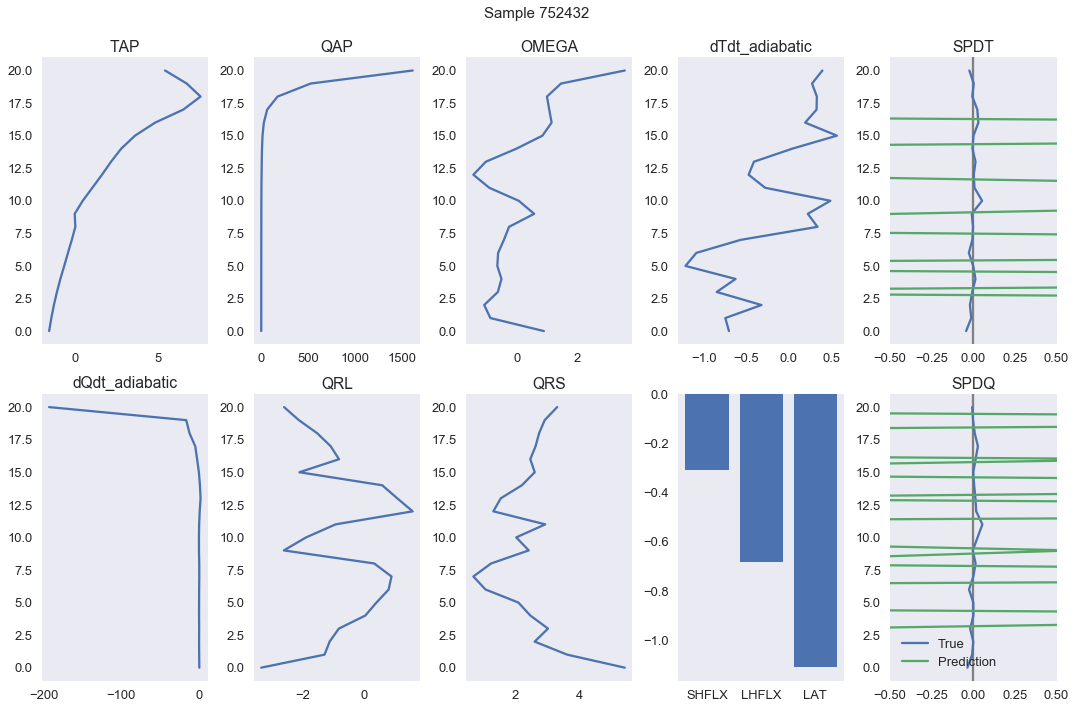

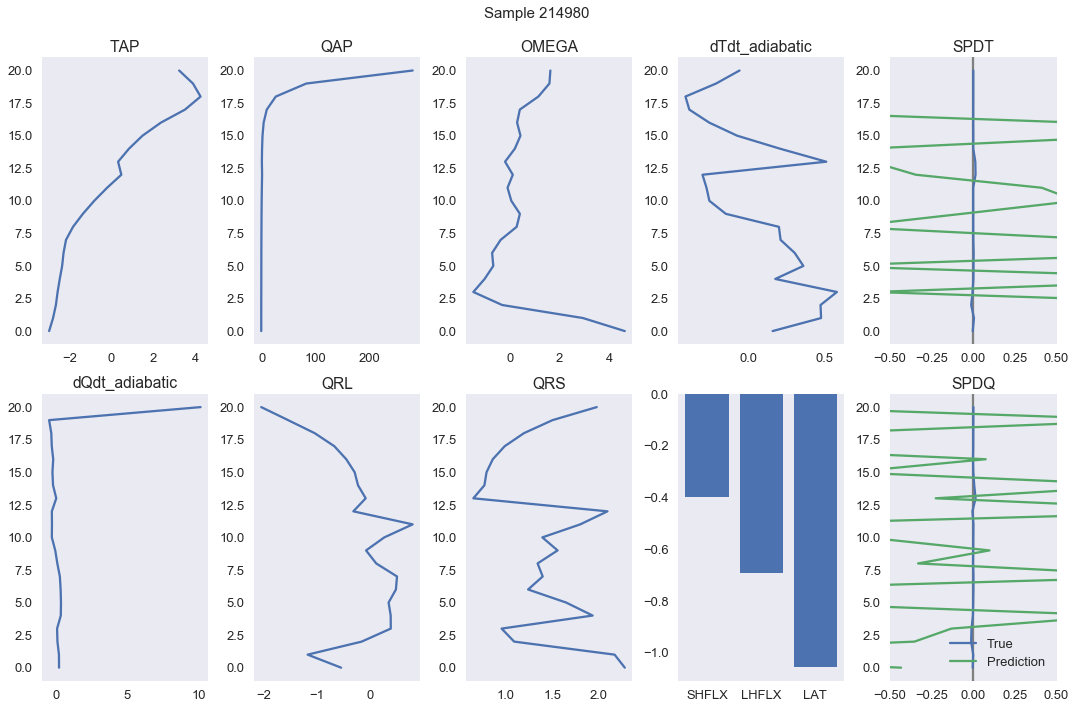

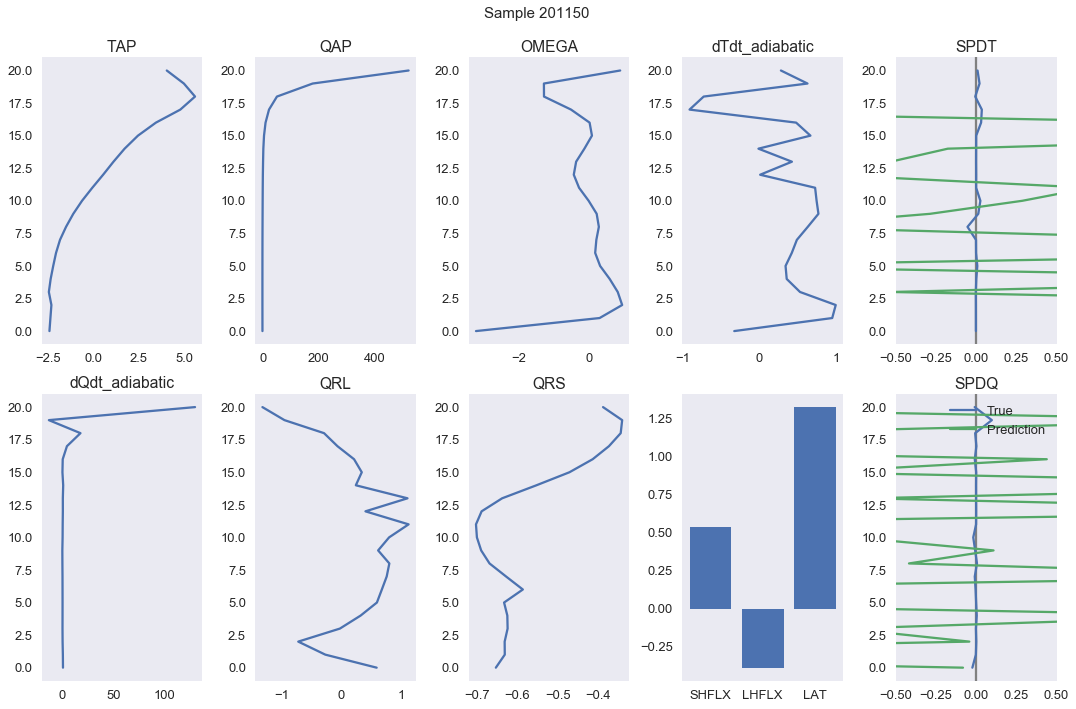

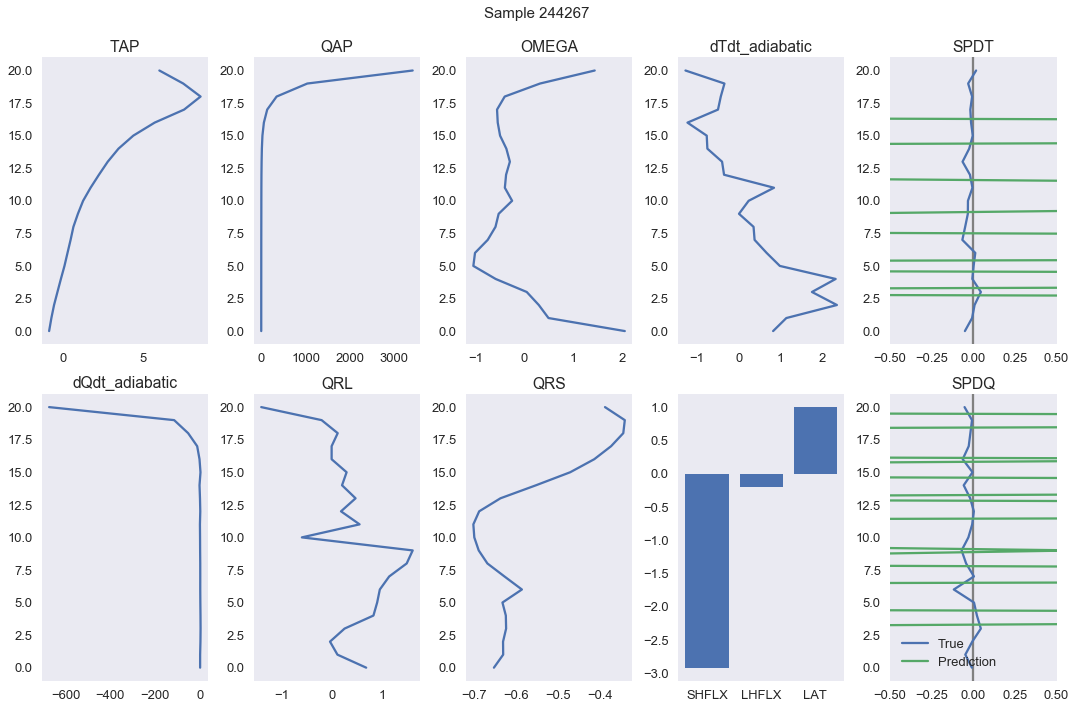

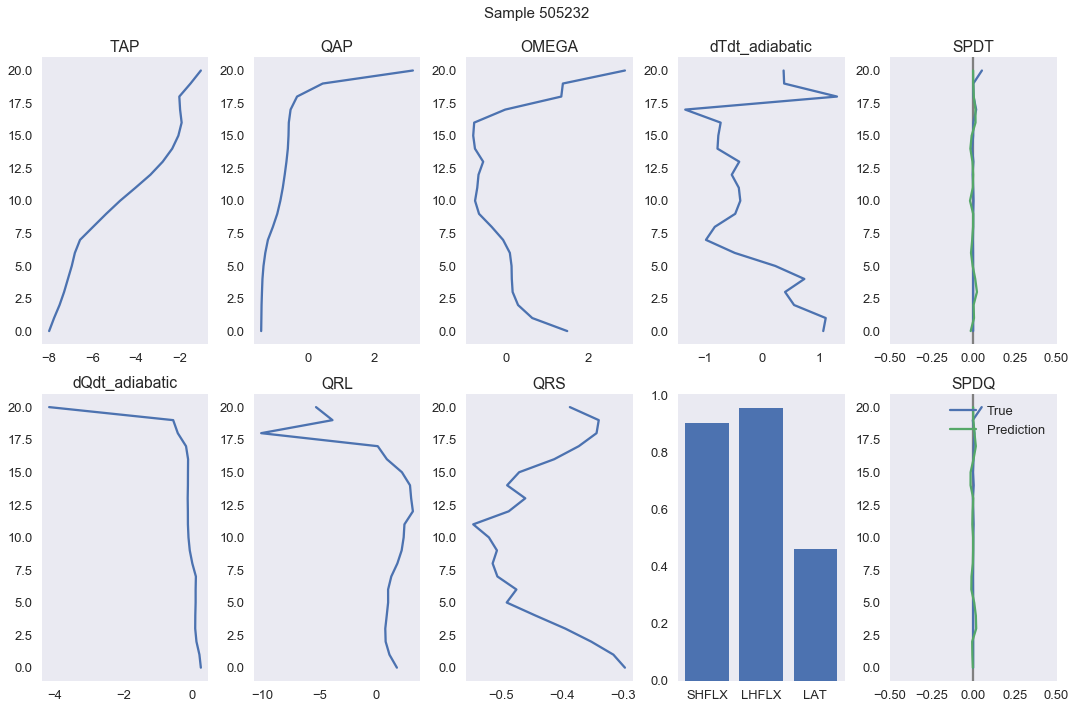

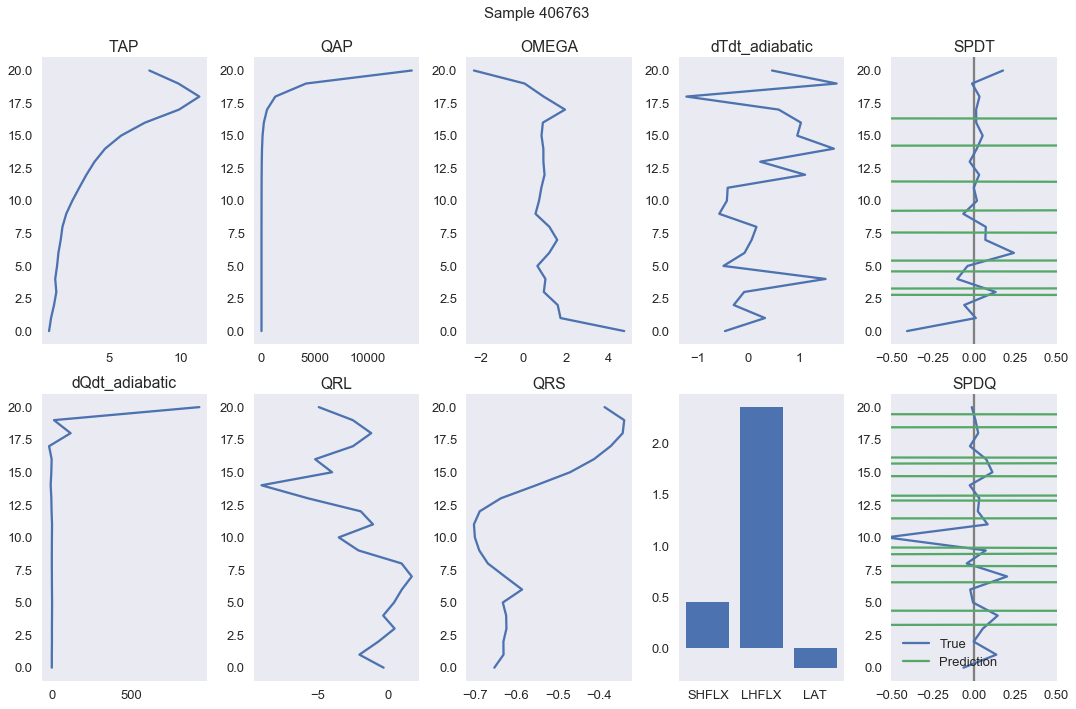

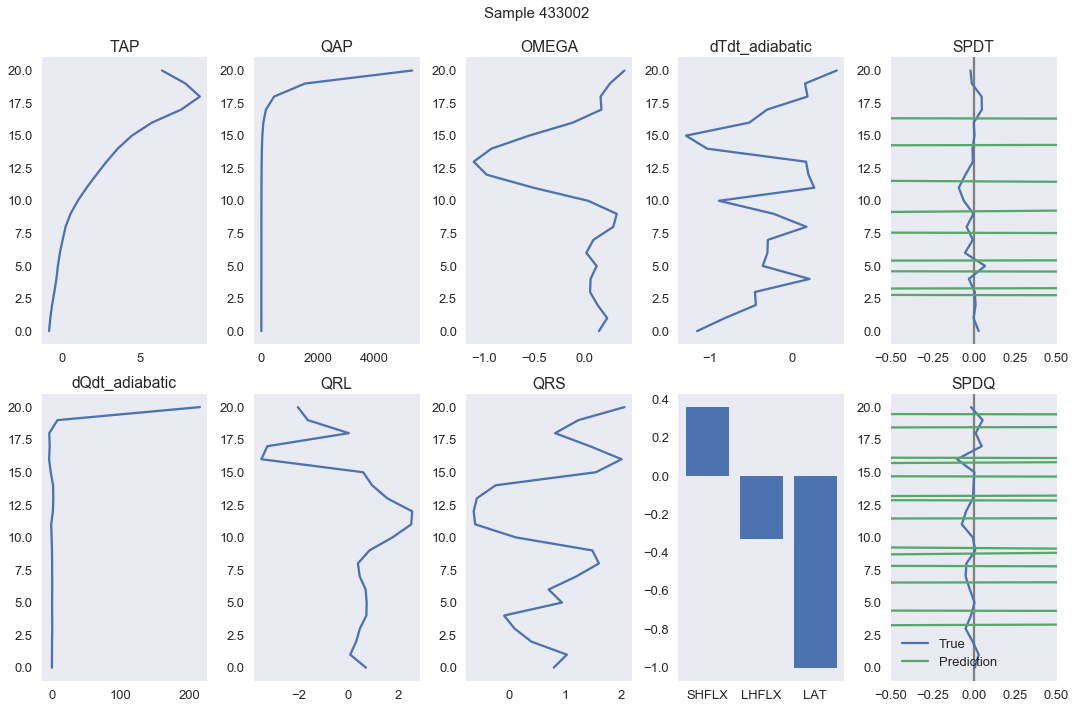

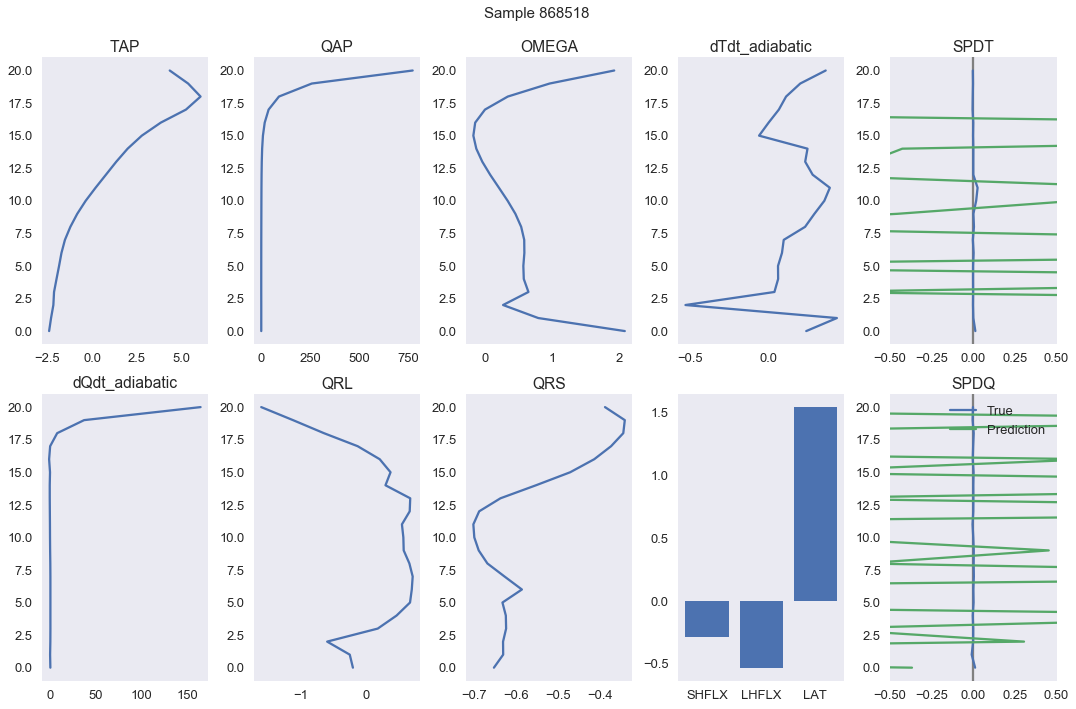

In [54]:
for i in list(np.random.randint(0, valid_set.features[0].shape[0], 10)):
    plot_stuff(valid_set.features[0], valid_set.features[1], valid_set.targets, preds,
               i, list(valid_set.feature_names), valid_set.target_names)

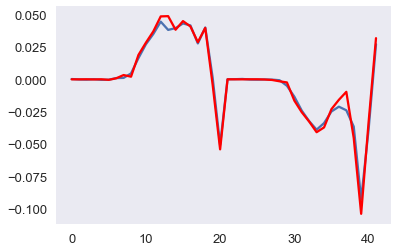

In [37]:
plt.plot(preds[i])
plt.plot(valid_set.targets[i], c='r')
plt.show()

In [55]:
# split into spdt and spdq
preds = np.reshape(preds, (preds.shape[0], 21, 2))
true = np.reshape(valid_set.targets, (valid_set.targets.shape[0], 21, 2))

In [112]:
# E along z axis
error = preds[:, :, :] - true[:preds.shape[0], :, :] 
error = np.reshape(error, (error.shape[0], -1))
error_dt = preds[:, :, 0] - true[:preds.shape[0], :, 0] 
error_dq = preds[:, :, 1] - true[:preds.shape[0], :, 1]

In [58]:
mae = np.mean(np.abs(preds[:, :, :] - true[:preds.shape[0], :, :]))
mae

0.016872659388635268

In [59]:
np.mean(np.abs(preds[:, :, 0] - true[:preds.shape[0], :, 0]))

0.016644356283999021

In [60]:
np.mean(np.abs(preds[:, :, 1] - true[:preds.shape[0], :, 1]))

0.017100962493271643

In [96]:
np.mean(np.abs(true[:preds.shape[0], :, :]))

0.025882592534425354

In [70]:
lats = valid_batches.features[1][:preds.shape[0], -1]

In [77]:
# RMSE
def rmse_stat(x):
    return np.sqrt(np.mean(x**2))

In [84]:
def plot_lat_z_statistic(a, lats, statistic, cmap='inferno', vmin=None, vmax=None):
    b = binned_statistic(lats, a.T, statistic=statistic, bins=20, 
                         range=(lats.min(), lats.max()))
    mean_lats = (b[1][1:] + b[1][:-1]) / 2.
    mean_lats = ['%.0f' % l for l in mean_lats]
    plt.imshow(b[0], cmap=cmap, vmin=vmin, vmax=vmax)
    plt.xticks(range(len(mean_lats)), mean_lats)
    plt.colorbar()
    plt.show()

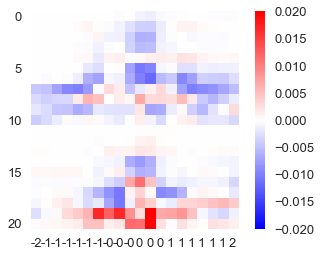

In [86]:
plot_lat_z_statistic(error_dt, lats, 'mean', 'bwr', -0.02, 0.02)

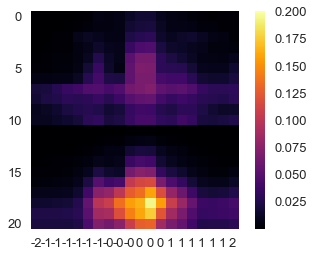

In [91]:
plot_lat_z_statistic(error_dt, lats, rmse_stat, vmax=0.2)

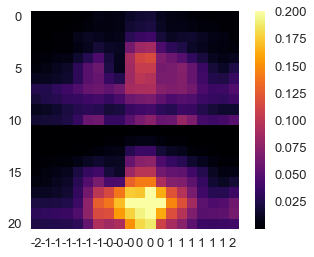

In [94]:
plot_lat_z_statistic(true[:preds.shape[0], :, 0], lats, np.std, vmax=0.2)

In [95]:
train_preds = model.predict_generator(train_batches.generate(shuffle=False), 
                                      train_batches.n_batches)

In [98]:
train_preds = np.reshape(train_preds, (train_preds.shape[0], 21, 2))
train_true = np.reshape(train_batches.targets, (train_batches.targets.shape[0], 21, 2))
train_preds.shape, train_true.shape

((3696128, 21, 2), (3696230, 21, 2))

In [99]:
# E along z axis
train_error_dt = train_preds[:, :, 0] - train_true[:train_preds.shape[0], :, 0] 
train_error_dq = train_preds[:, :, 1] - train_true[:train_preds.shape[0], :, 1]

In [100]:
np.mean(np.abs(train_preds[:, :, :] - train_true[:train_preds.shape[0], :, :]))

0.016851513251780553

In [101]:
np.mean(np.abs(train_true[:train_preds.shape[0], :, :]))

0.025881500968938109

In [102]:
var = np.var(true)
var

0.004203581800124913

In [105]:
se = np.mean((preds[:, :, :] - true[:preds.shape[0], :, :]) ** 2)
se

0.0018571880335468524

In [106]:
1 - (se / var)

0.55818915347581322

In [107]:
se / var

0.44181084652418673

In [108]:
0.016/0.025

0.64

In [113]:
binned_se = binned_statistic(lats, error.T ** 2, statistic=np.mean, bins=20,
                              range=(lats.min(), lats.max()))

In [118]:
np.reshape(true, (true.shape[0], -1)).T[:, :preds.shape[0]]

(42, 924058)

In [119]:
error.T.shape

(42, 924032)

In [120]:
binned_var = binned_statistic(lats, np.reshape(true, (true.shape[0], -1)).T[:, :preds.shape[0]],
                              statistic=np.var, bins=20,
                              range=(lats.min(), lats.max()))

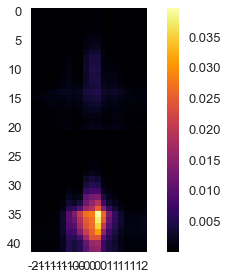

In [122]:
plt.imshow(binned_se[0], cmap='inferno')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

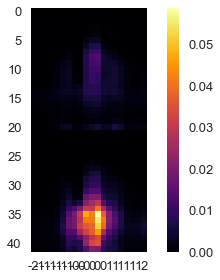

In [123]:
plt.imshow(binned_var[0], cmap='inferno')
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

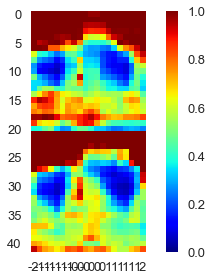

In [129]:
plt.imshow(binned_se[0] / binned_var[0], cmap='jet', vmin=0, vmax=1)
plt.xticks(range(len(mean_lats)), mean_lats)
plt.colorbar()
plt.tight_layout()
plt.show()

1271.2118255735274